# **SPH6004 Advanced Statistical Learning**
Indvidual Assignment 1  
Name: Palvinder Kaur D/O Satwant Singh  
Student ID: A0113283N  

## **1. AIM** 
The aim is to predict risk of intubation in the intensive care unit.  

*Assignment objectives*
* Develop and implement predictive lrs on a static structure dataset
* Develop and implement feature selection methods to enhance prediction lrs
* Analyse and explain the differences in performance from different lrs 

## **2. PRE-PROCESSING**

### 2.1. IMPORT LIBRARIES AND DATA

In [39]:
# 2.1.1 IMPORT LIBRARIES

## Numpy is for math operations and Panda is for processing tabular data
import pandas as pd
import numpy as np
# preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler # for standardization
# for plotting graphs and constructing tables
import matplotlib.pyplot as plt
import seaborn as sns
from tableone import TableOne
import plotly.graph_objects as go
import plotly.express as px

# for imputation 
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer 

# for model builidng 
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, ParameterGrid
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, average_precision_score, roc_curve, accuracy_score, precision_recall_curve, auc, classification_report, make_scorer
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression as logit # use build-in logistic regression model in sklearn
from sklearn.feature_selection import SequentialFeatureSelector as sfs
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier as dtc, plot_tree, export_graphviz
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier as abc, GradientBoostingClassifier as gbc
from xgboost import XGBClassifier as xgbc
from sklearn.svm import SVC

# for gradient descent
import torch
import torch.nn as nn
from torch.optim import SGD 

# for oversampling minority class - smote
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline

# for outliers
#import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# 2.1.2  IMPORT DATA 

# read data
data = pd.read_csv("Assignment_1_data.csv")

# view the first ten rows of the dataset
data[0:10]

# view the description of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36489 entries, 0 to 36488
Data columns (total 60 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   gender                      36489 non-null  object 
 1   age                         36489 non-null  float64
 2   heart_rate_min              36417 non-null  float64
 3   heart_rate_max              36417 non-null  float64
 4   heart_rate_mean             36417 non-null  float64
 5   mbp_min                     36401 non-null  float64
 6   mbp_max                     36401 non-null  float64
 7   mbp_mean                    36401 non-null  float64
 8   sbp_min                     36343 non-null  float64
 9   sbp_max                     36343 non-null  float64
 10  sbp_mean                    36343 non-null  float64
 11  dbp_min                     36341 non-null  float64
 12  dbp_max                     36341 non-null  float64
 13  dbp_mean                    363

### 2.2. DATA CLEANING

In [3]:
# 2.2.1  CONVERT STRING VARIABLES TO BINARY VARIABLES

# outcome variable
data.head()
le=LabelEncoder()
label=le.fit_transform(data['outcome'])
le.classes_
data=data.drop('outcome',axis=1)
data['outcome']=label
data.head()
data.outcome.value_counts()

# gender variable - convert to binary
data.head()
le=LabelEncoder()
label1=le.fit_transform(data['gender'])
le.classes_
data=data.drop('gender', axis=1)
data['gender']=label1


cols = data.columns.tolist() # this part of the code is to move this gender variable to the first column of the dataset
cols.remove('gender')
cols.insert(cols.index('age'), 'gender')
data = data.reindex(columns=cols)
data.head()
data.gender.value_counts() #male =1 

# generate a new variable - sofa_total 
data['sofa_total'] = data[['sofa_respiration', 'sofa_cardiovascular', 'sofa_coagulation', 'sofa_liver', 'sofa_renal', 'sofa_cns']].sum(axis=1, skipna=True)

# order sofa_total before charlson comorbidity index
cols = data.columns.tolist()
cols.remove('sofa_total')
cols.insert(cols.index('charlson_comorbidity_index'), 'sofa_total')
data = data.reindex(columns=cols)

# print out the first few rows to check the results
print(data.head())

   gender        age  heart_rate_min  heart_rate_max  heart_rate_mean  \
0       1  54.550390            93.0           115.0       103.500000   
1       1  86.324653            50.0            61.0        54.333333   
2       1  40.270146            70.0           105.0        83.434783   
3       1  73.383547            68.0            98.0        83.880000   
4       1  70.724748            77.0            95.0        85.771429   

   mbp_min  mbp_max   mbp_mean  sbp_min  sbp_max  ...  urineoutput  \
0     57.0    100.0  82.733333     87.0    163.0  ...       3459.0   
1     61.0     93.0  71.695652     95.0    141.0  ...       2020.0   
2     66.0     92.0  76.695652     94.0    129.0  ...       3050.0   
3     74.0    101.0  84.694444     83.0    148.0  ...       1592.0   
4     30.0     90.0  62.657143     52.0    129.0  ...        339.0   

   sofa_respiration  sofa_coagulation  sofa_liver  sofa_cardiovascular  \
0               2.0               0.0         NaN                 

### 2.3. MISSING DATA ANALYSIS 

In [4]:
# 2.3.1 CREATE TABLEONE TO GET AN OVERVIEW OF THE DATASET BEFORE IMPUTATION 

columns = ['gender','age','heart_rate_min', 'heart_rate_max', 'heart_rate_mean', 'mbp_min', 'mbp_max', 'mbp_mean', 'sbp_min',
    'sbp_max', 'sbp_mean', 'dbp_min', 'dbp_max', 'dbp_mean', 'temperature_min', 'temperature_max', 'temperature_mean',
    'lactate_min', 'lactate_max', 'ph_min', 'ph_max', 'chloride_min', 'chloride_max', 'calcium_min', 'calcium_max', 
    'sodium_min', 'sodium_max', 'glucose_min', 'glucose_max', 'wbc_min', 'wbc_max', 'creatinine_min', 'creatinine_max',
    'hemoglobin_min', 'hemoglobin_max', 'total_protein_min', 'total_protein_max', 'pt_min', 'pt_max', 'alt_min', 'alt_max', 
    'alp_min', 'alp_max', 'ast_min', 'ast_max', 'bilirubin_total_min', 'bilirubin_total_max', 'bilirubin_direct_min',
    'bilirubin_direct_max', 'bilirubin_indirect_min', 'bilirubin_indirect_max', 'urineoutput', 
    'sofa_respiration', 'sofa_coagulation','sofa_liver', 'sofa_cardiovascular', 'sofa_cns', 'sofa_renal', 'sofa_total','charlson_comorbidity_index',
    'outcome']
categorical = ['gender']
nonnormal = ['age', 'alp_max', 'alp_min', 'alt_max', 'alt_min', 'ast_max', 'ast_min', 'bilirubin_direct_max', 'bilirubin_direct_min', 
     'bilirubin_indirect_max', 'bilirubin_indirect_min', 'bilirubin_total_max', 'bilirubin_total_min', 'calcium_max', 
     'calcium_min', 'charlson_comorbidity_index', 'chloride_max', 'chloride_min', 'creatinine_max', 'creatinine_min', 
     'dbp_max', 'dbp_mean', 'dbp_min', 'glucose_max', 'glucose_min', 'heart_rate_max', 'heart_rate_mean', 'heart_rate_min', 
     'hemoglobin_max', 'hemoglobin_min', 'lactate_max', 'lactate_min', 'mbp_max', 'mbp_mean', 'mbp_min', 
     'ph_max', 'ph_min', 'pt_max', 'pt_min', 'sbp_max', 'sbp_mean', 'sbp_min', 'sodium_max', 'sodium_min', 
     'sofa_cardiovascular', 'sofa_cns', 'sofa_coagulation', 'sofa_liver', 'sofa_renal', 'sofa_respiration', 'sofa_total', 'temperature_max', 
     'temperature_mean', 'temperature_min', 'total_protein_max', 'total_protein_min', 'urineoutput', 'wbc_max', 'wbc_min',]
groupby=['outcome']

def normal_test(x):
     stat, p = shapiro(x)
     return p

table1 = TableOne(data, columns=columns, categorical=categorical,nonnormal=nonnormal, groupby=groupby, pval=True, missing=True, 
     normal_test=normal_test, tukey_test=True, htest_name=True)
print(table1.tabulate(tablefmt="github"))
table1.to_excel('table1.xlsx', sheet_name='table1') #save table to excel

print(table1)

|                                            |    | Missing   | Overall                | 0                      | 1                     | P-Value   | Test           |
|--------------------------------------------|----|-----------|------------------------|------------------------|-----------------------|-----------|----------------|
| n                                          |    |           | 36489                  | 35160                  | 1329                  |           |                |
| gender, n (%)                              | 0  | 0         | 16609 (45.5)           | 16079 (45.7)           | 530 (39.9)            | <0.001    | Chi-squared    |
|                                            | 1  |           | 19880 (54.5)           | 19081 (54.3)           | 799 (60.1)            |           |                |
| age, median [Q1,Q3]                        |    | 0         | 67.4 [55.5,78.7]       | 67.4 [55.5,78.8]       | 67.3 [56.3,76.7]      | 0.187     | Kruskal-Wallis 

In [5]:
# 2.3.2 ASSESS MISSING DATA BY OUTCOME 

# When stratified by outcome, there was higher % of missing values in the group without intubation vs the group with intubation. 
# This could be because patients who do not require intubation at that point of time may not have been severe enough to warrant the need for further tests. 
# As such, missing at random is a plausible explanation for the missing data.

def count_missing(x):
    return (x.isnull()).sum()

table2 = data.groupby('outcome').agg({col: count_missing for col in data.columns[1:]}).T 
print(table2)

table2.to_excel('table2.xlsx', sheet_name='table2') #save table to excel

outcome                         0     1
age                             0     0
heart_rate_min                 72     0
heart_rate_max                 72     0
heart_rate_mean                72     0
mbp_min                        88     0
mbp_max                        88     0
mbp_mean                       88     0
sbp_min                       142     4
sbp_max                       142     4
sbp_mean                      142     4
dbp_min                       144     4
dbp_max                       144     4
dbp_mean                      144     4
temperature_min               358     5
temperature_max               358     5
temperature_mean              358     5
lactate_min                 20059   500
lactate_max                 20059   500
ph_min                      17245   384
ph_max                      17245   384
chloride_min                29259  1101
chloride_max                29259  1101
calcium_min                 26366   834
calcium_max                 26366   834


In [6]:
# # 2.3.3 DROP 26 VARIABLES WITH AT ALEAST >=40% MISSING VALUES 

# As they are unstable for prediction (reference:Harrel et al and TRIPOD framework). 

data_2 = data.drop(['lactate_min', 'lactate_max', 'ph_min', 'ph_max', 'chloride_min', 'chloride_max', 'calcium_min', 'calcium_max', 
    'sodium_min', 'sodium_max', 'total_protein_min', 'total_protein_max', 'alt_min', 'alt_max', 'alp_min', 'alp_max', 
    'ast_min', 'ast_max', 'bilirubin_total_min', 'bilirubin_total_max','bilirubin_direct_min', 'bilirubin_direct_max', 
    'bilirubin_indirect_min', 'bilirubin_indirect_max'], axis=1)

data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36489 entries, 0 to 36488
Data columns (total 37 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   gender                      36489 non-null  int32  
 1   age                         36489 non-null  float64
 2   heart_rate_min              36417 non-null  float64
 3   heart_rate_max              36417 non-null  float64
 4   heart_rate_mean             36417 non-null  float64
 5   mbp_min                     36401 non-null  float64
 6   mbp_max                     36401 non-null  float64
 7   mbp_mean                    36401 non-null  float64
 8   sbp_min                     36343 non-null  float64
 9   sbp_max                     36343 non-null  float64
 10  sbp_mean                    36343 non-null  float64
 11  dbp_min                     36341 non-null  float64
 12  dbp_max                     36341 non-null  float64
 13  dbp_mean                    363

### 2.4. DATA VISUALISATION BEFORE IMPUTATION

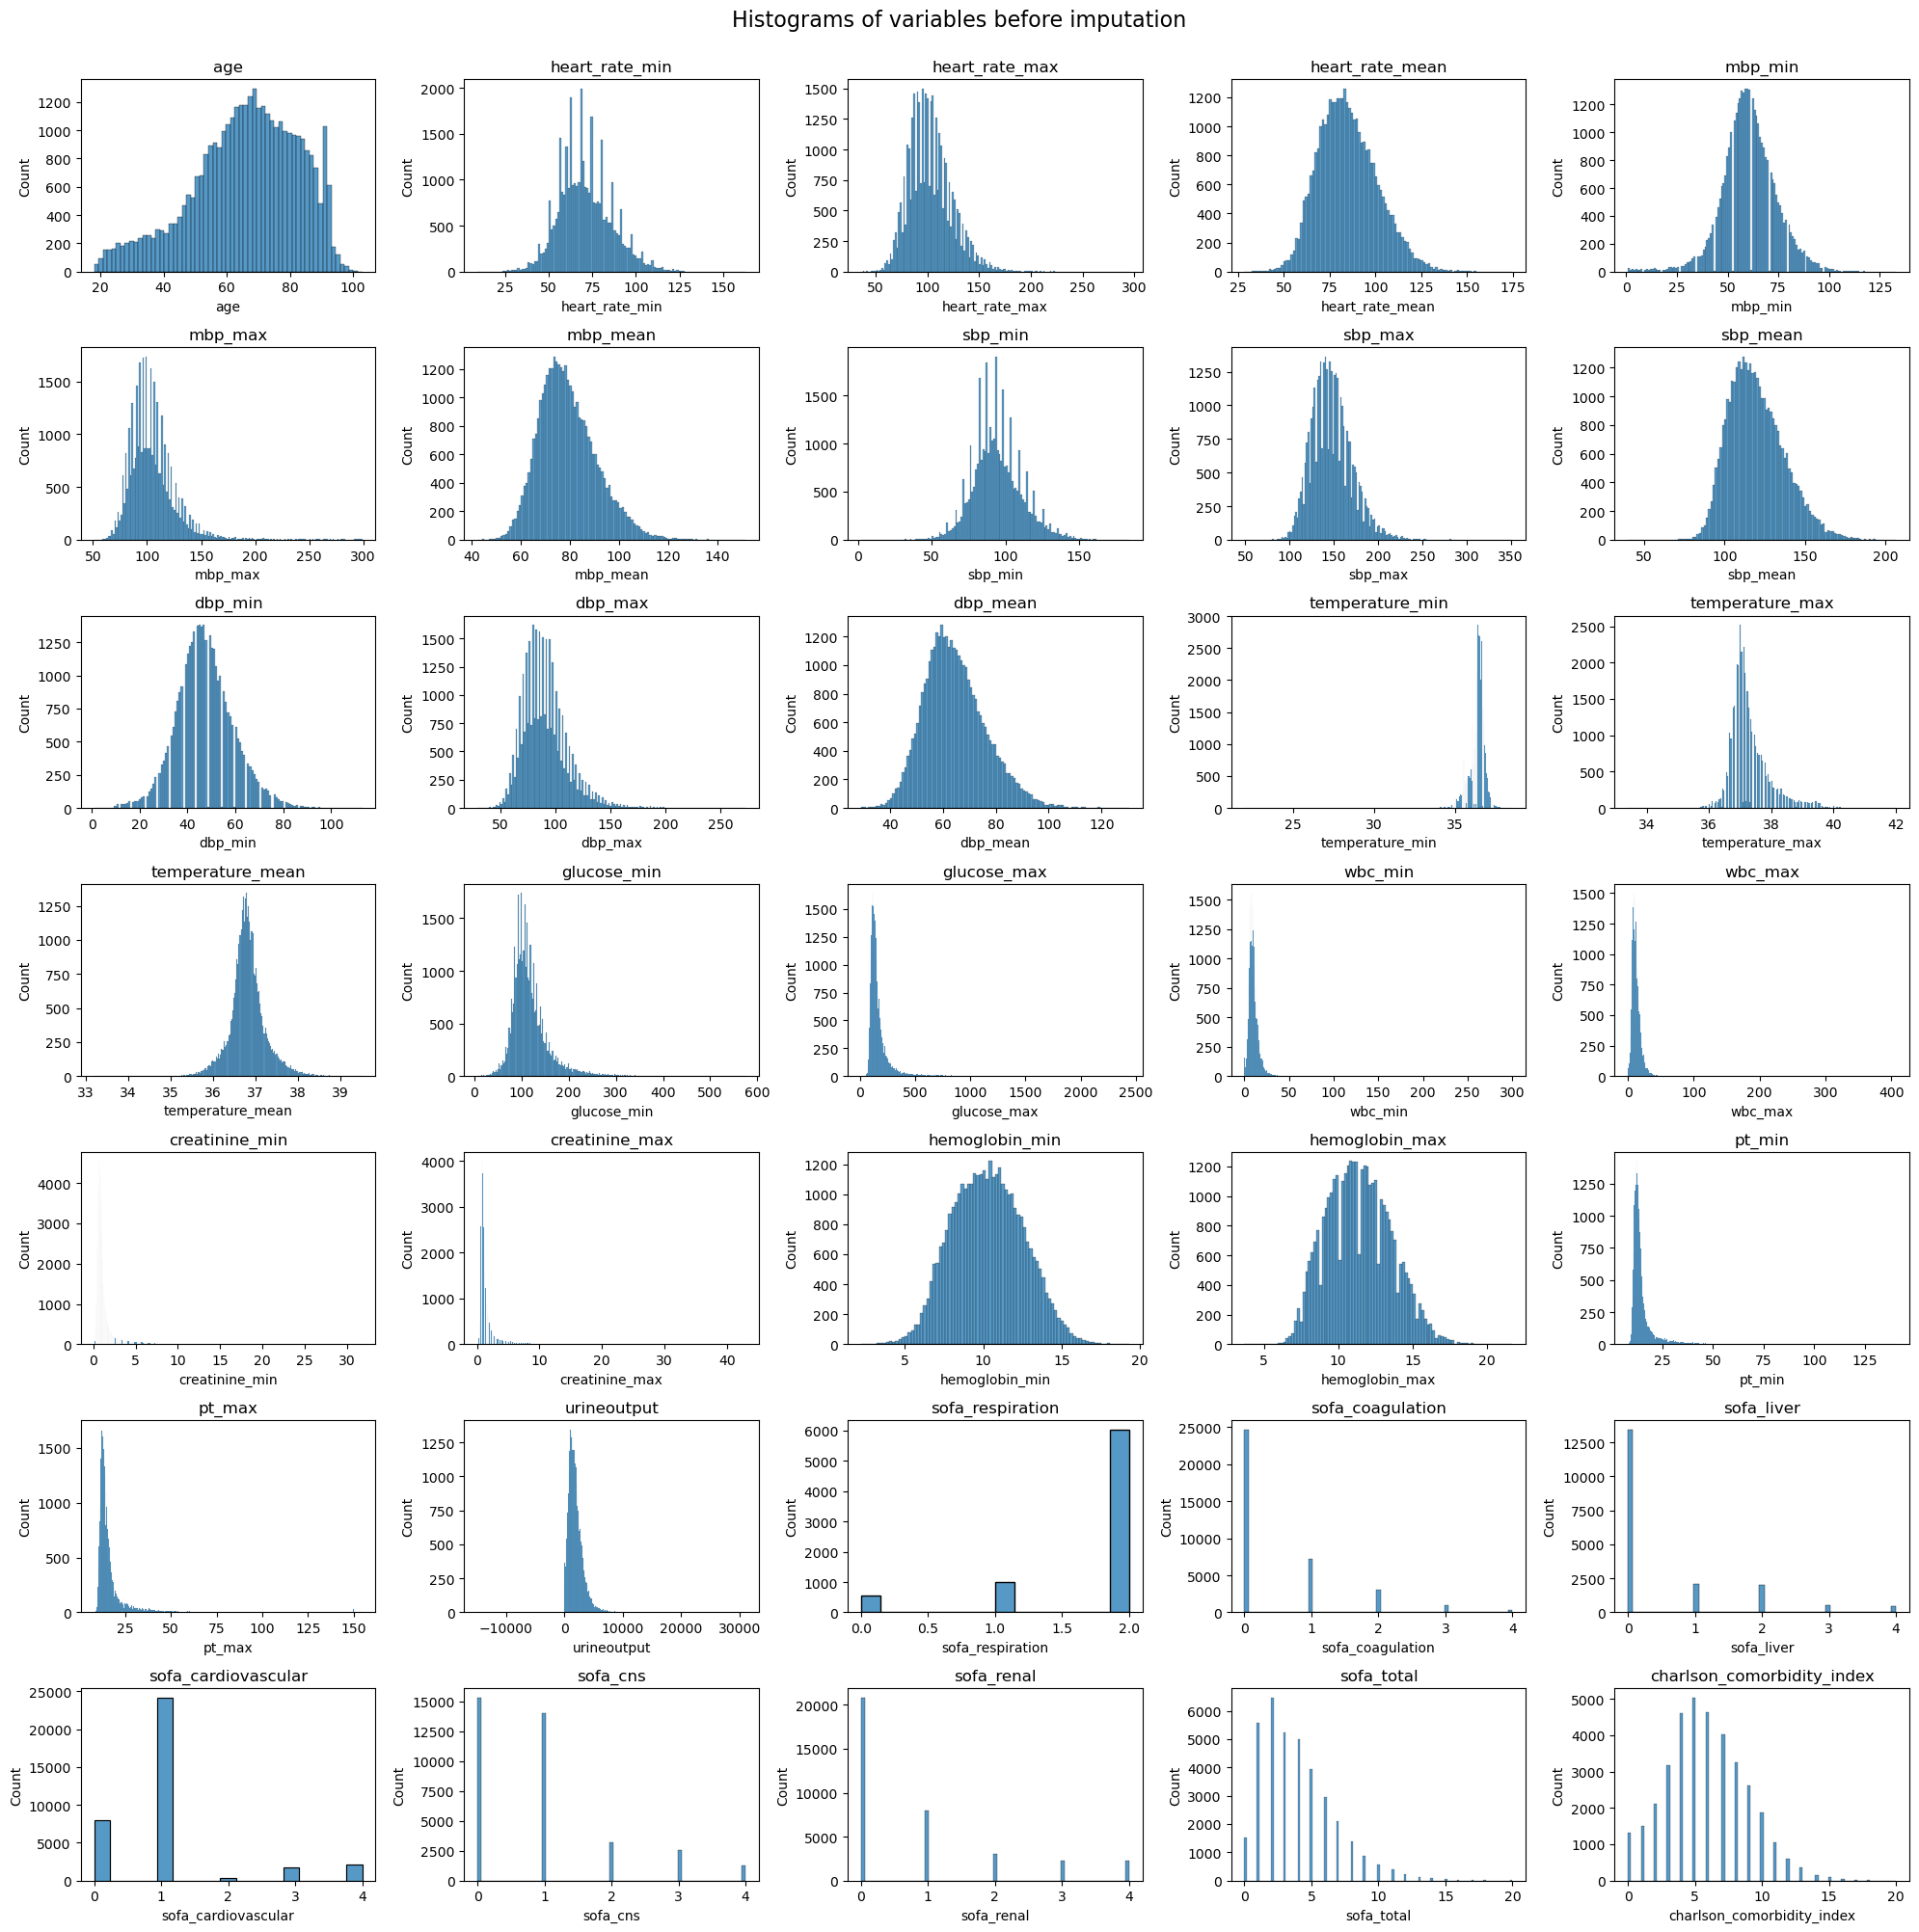

In [7]:
# 2.4.1 OVERVIEW OF THE DATA DISTRIBUTION BEFORE IMPUTATION 

# Histograms of variables were plotted before imputation was performed. 

# specify x variables to plot using boxplots
variable = data_2.loc[:, 'age':'charlson_comorbidity_index'].columns

# plot separate histograms for each variable in columns 1-32 (minus outcome) in a grid
fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(20, 20))
fig.suptitle('Histograms of variables before imputation', fontsize=16, y=1.0)
fig.subplots_adjust(hspace=0.5, wspace=0.5) #adjust space between the plots
for i, ax in enumerate(axes.flatten()):
    if i < 35:
        sns.histplot(x=variable[i], data=data_2, ax=ax,palette='Set2')
        ax.set_title(variable[i])
        ax.set_xlabel(variable[i])
        ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

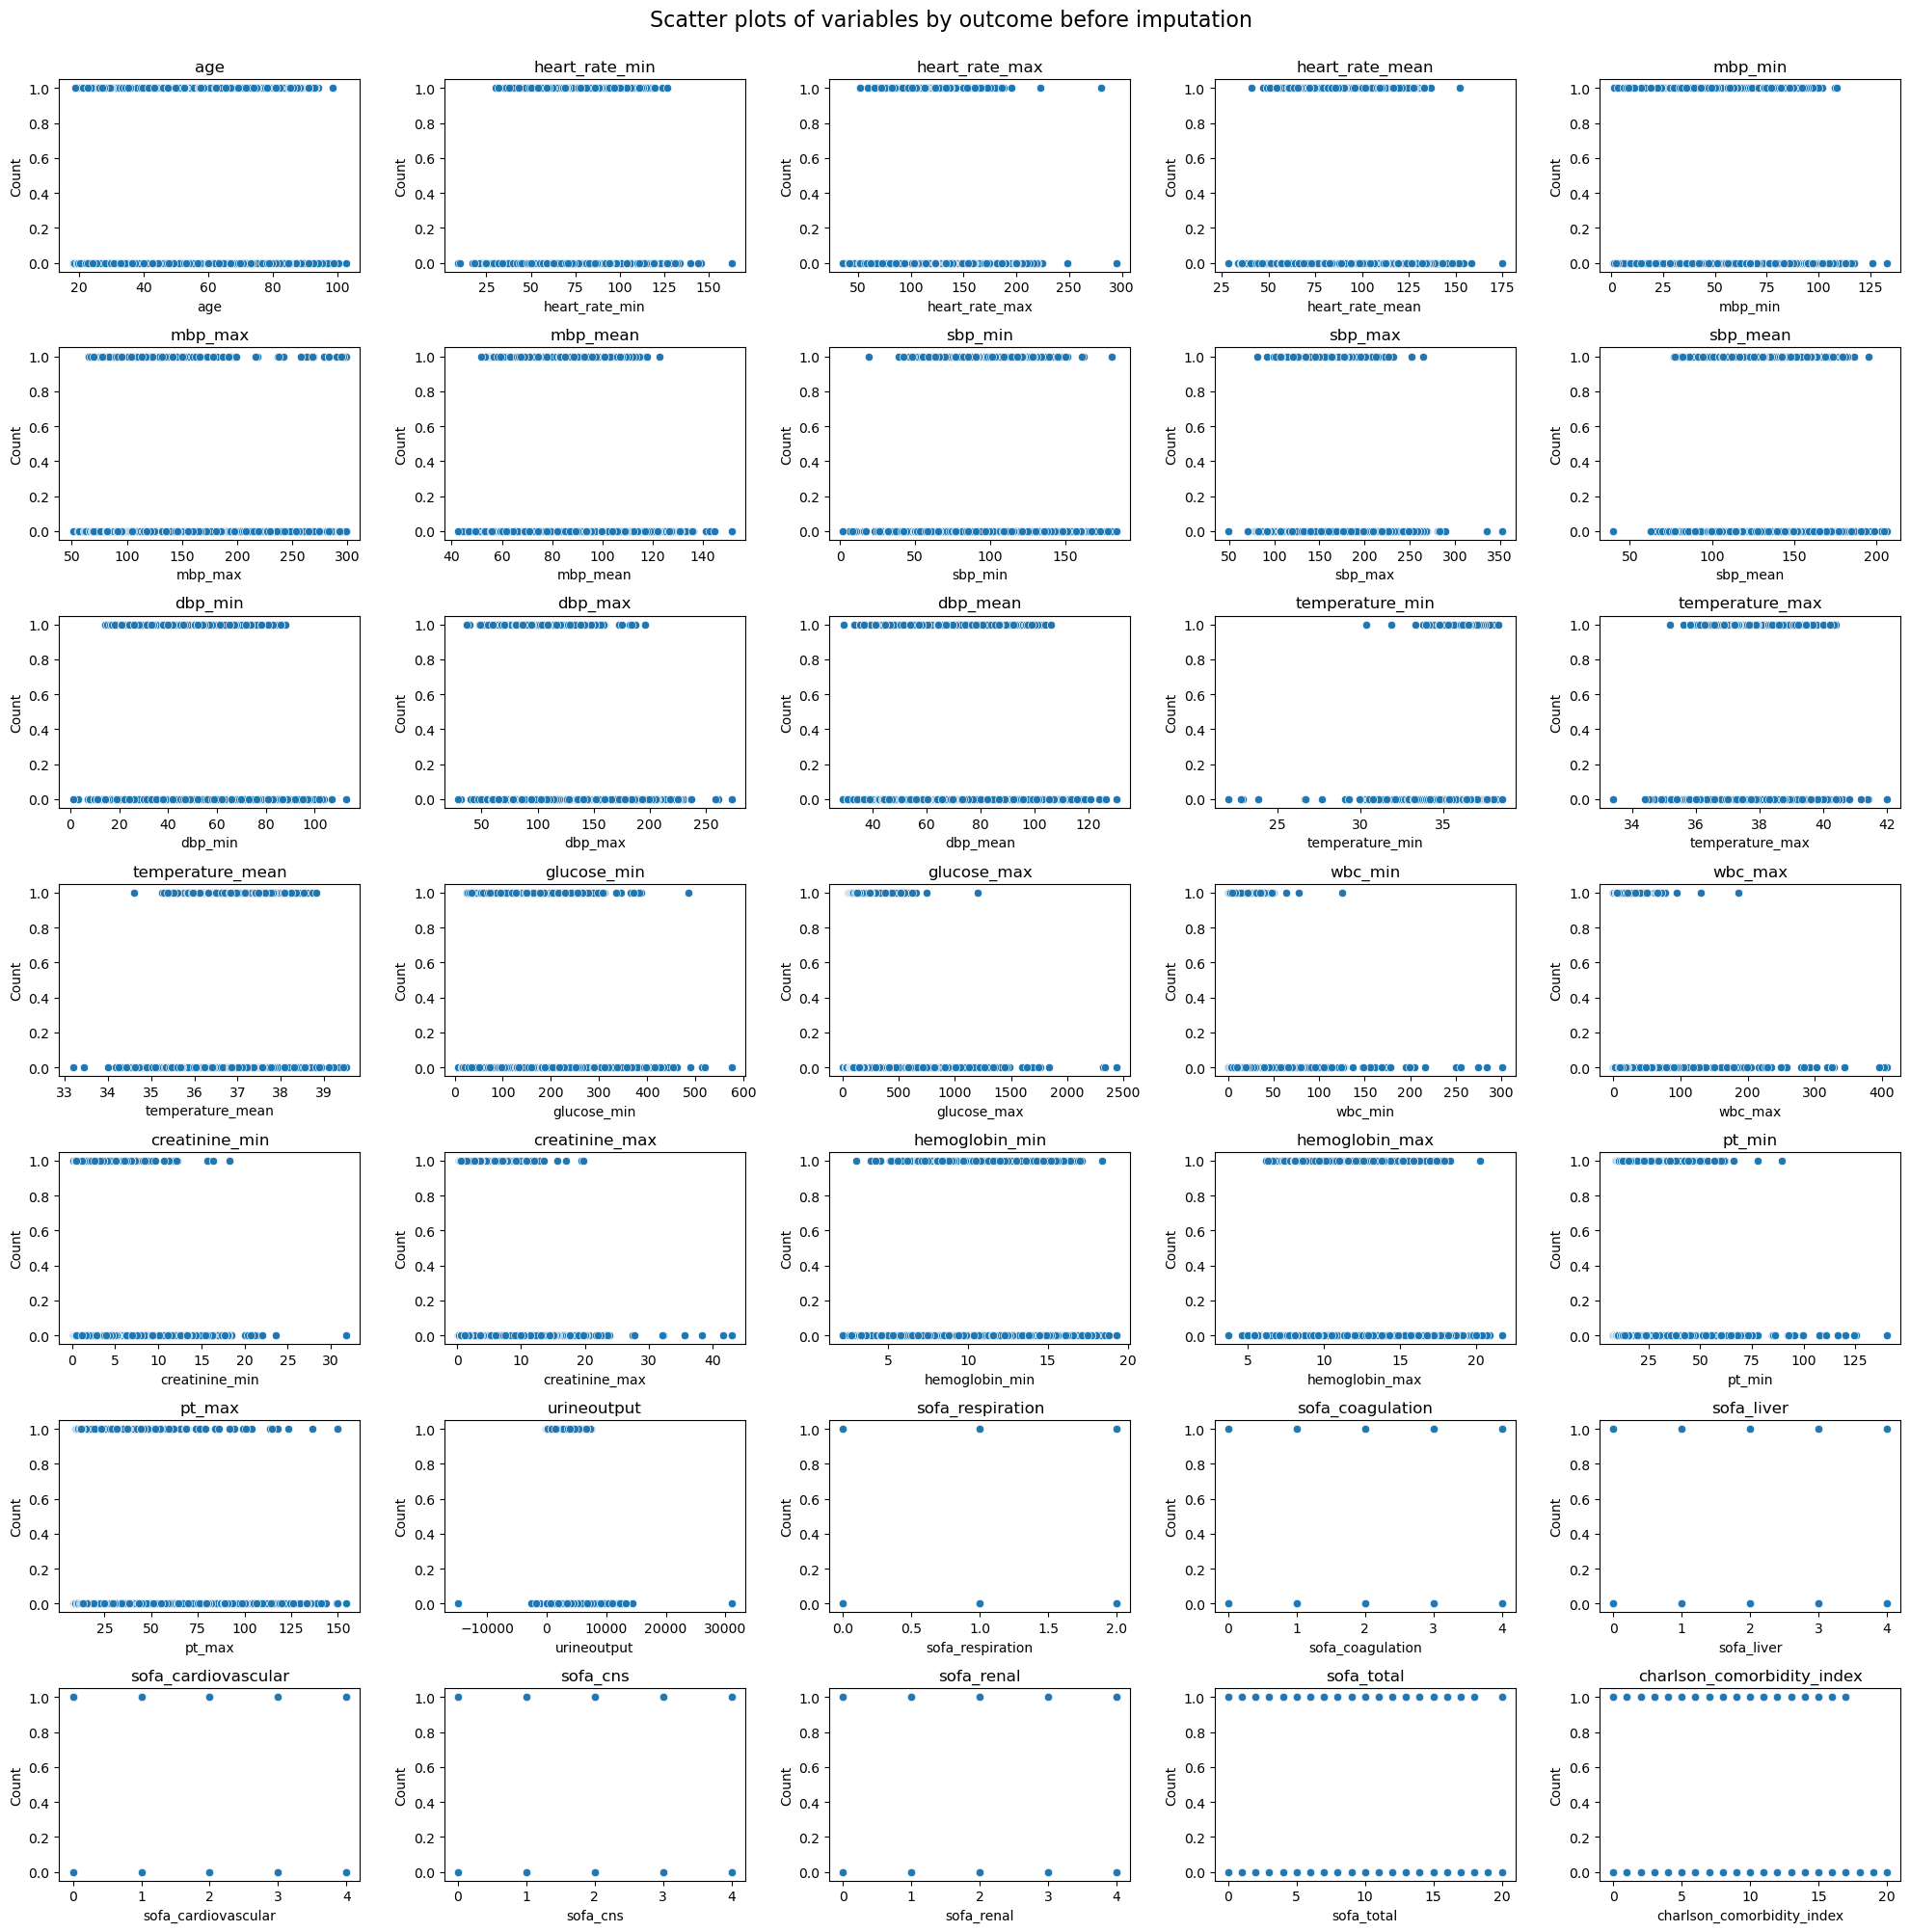

In [8]:
# 2.4.2 ASSESS FOR OUTLIERS

# to futher assess outliers, I have plotted scatterplots of each variable by outcome
# plot scatter plots for each variable in columns 1-32 by outcome in a grid
# from the plots, i see that there are outliers for almost all variables.

fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(20, 20))
fig.suptitle('Scatter plots of variables by outcome before imputation', fontsize=16, y=1.0)
fig.subplots_adjust(hspace=0.5, wspace=0.5) #adjust space between the plots
for i, ax in enumerate(axes.flatten()):
    if i < 35:
        sns.scatterplot(x=variable[i], y='outcome', data=data_2, ax=ax,palette='Set2')
        ax.set_title(variable[i])
        ax.set_xlabel(variable[i])
        ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

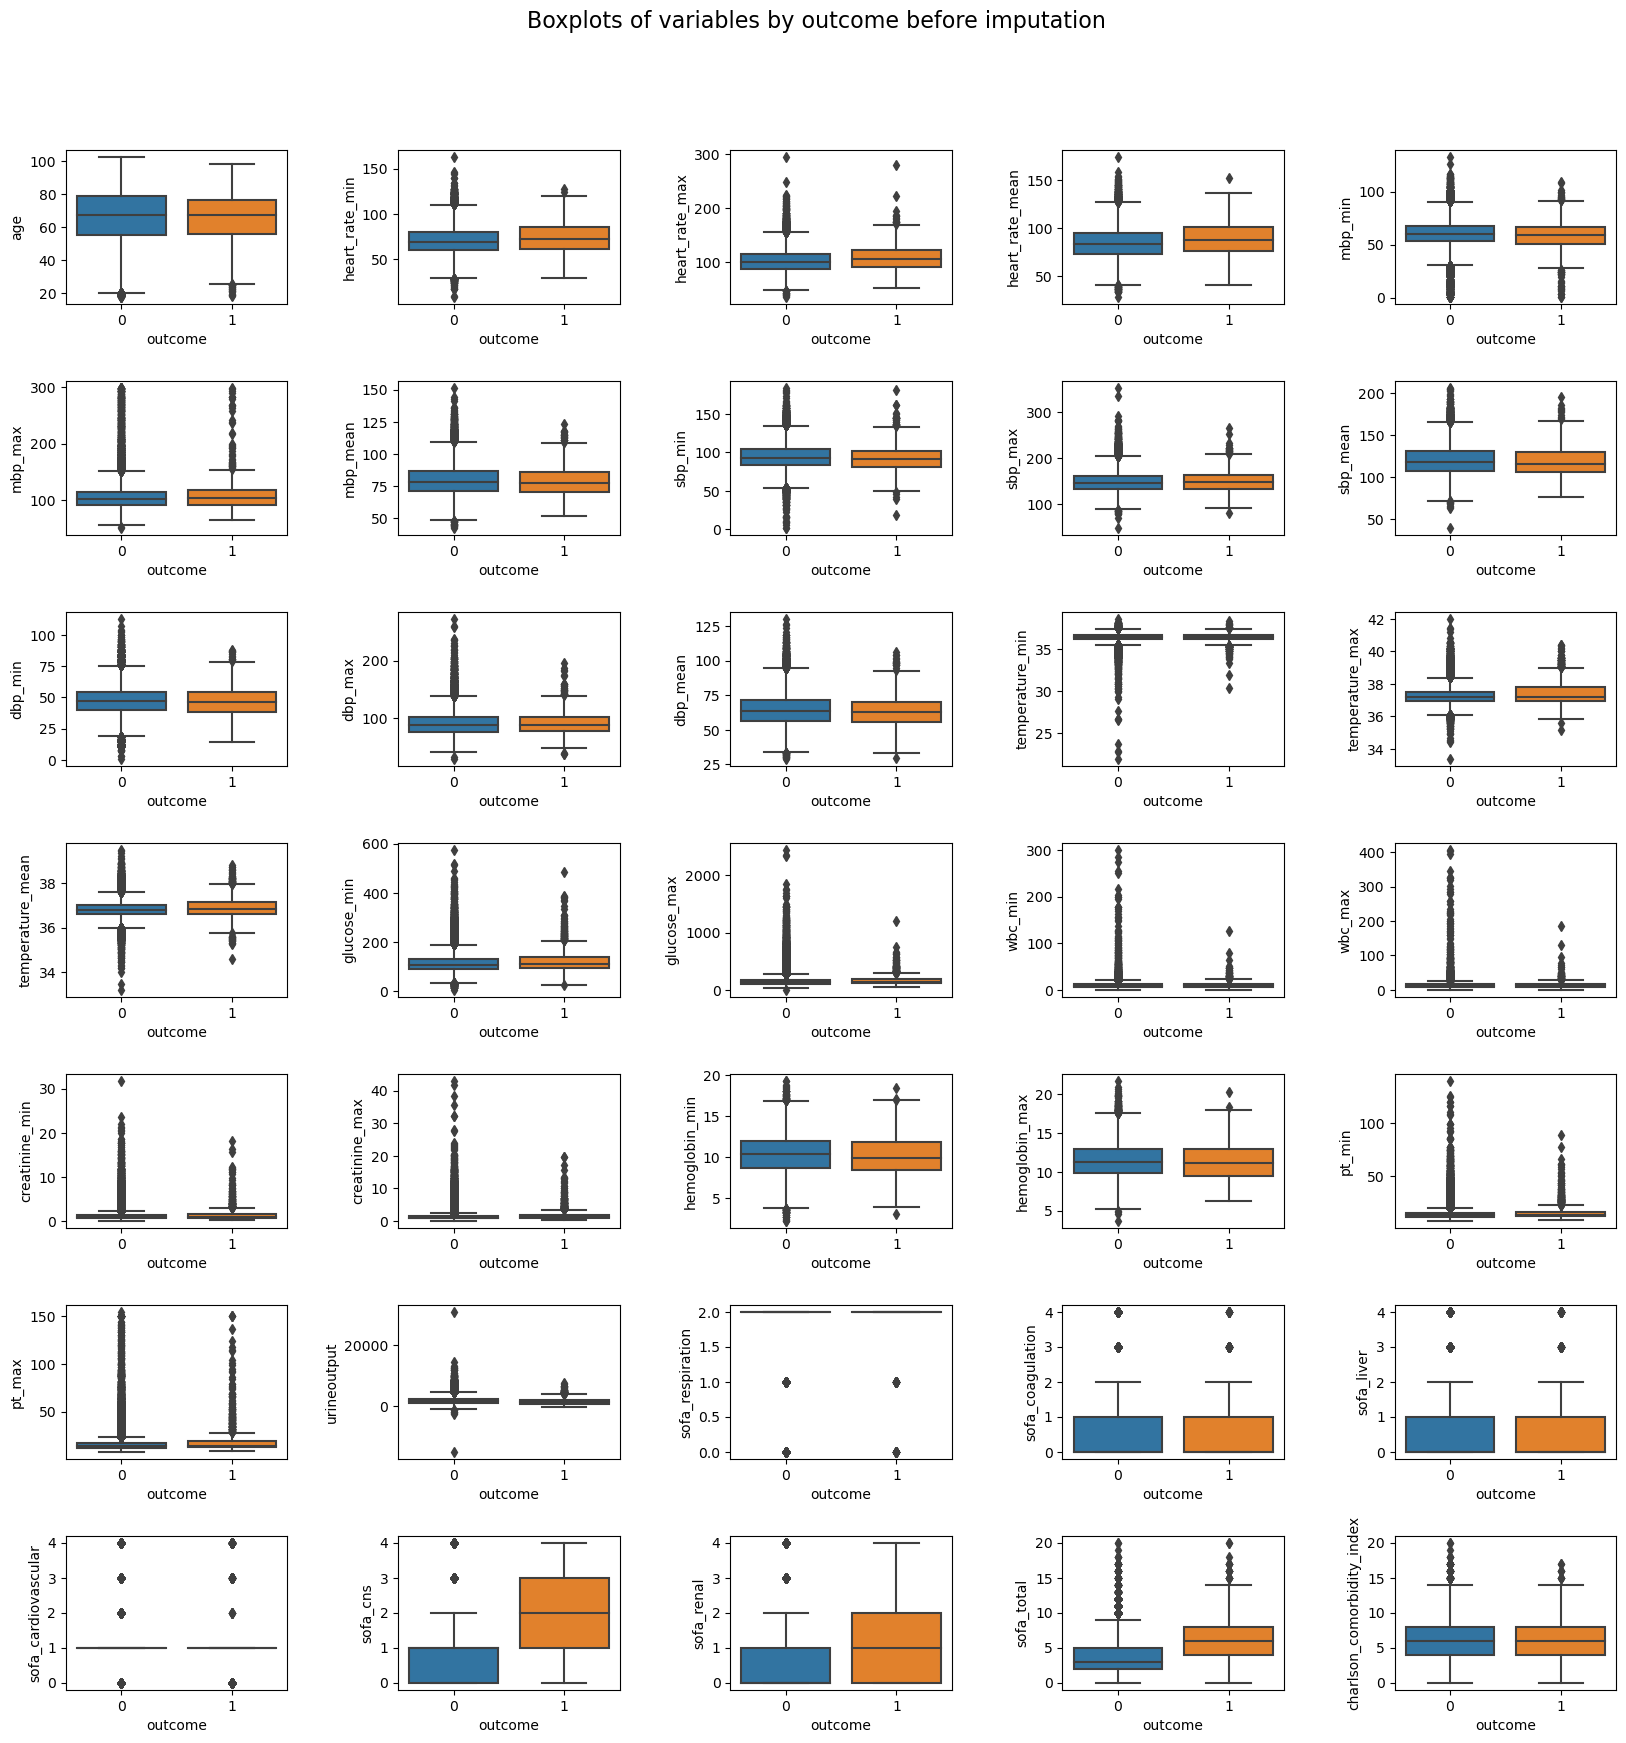

In [9]:
# 2.4.3 ASSESS FOR MEDIAN, 25TH AND 75TH PERCENTILES OF EACH VARIABLE BY OUTCOME

# plot boxplots for each variable by outcome in a grid
fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(20, 20))
fig.suptitle('Boxplots of variables by outcome before imputation', fontsize=16, y=0.95)
fig.subplots_adjust(hspace=0.5, wspace=0.5) #adjust space between the plots

count = 0
for var in variable:
    count += 1
    plt.subplot(7, 5, count)
    ax = sns.boxplot(x='outcome', y=var, data=data_2)
    
plt.show()

### 2.5. OUTLIER DETECTION AND REMOVAL

In [10]:
# 2.5.1 CHECK FOR OUTLIERS USING THE Z SCORE METHOD

# compute z-scores for all variables in variable [refer to line 6 in 2.4.1.]
z = np.abs(stats.zscore(data_2[variable], nan_policy='omit')) # np.abs returns the absolute value of the z-scores
print(z)
z.to_excel('z.xlsx', sheet_name='z') #save table to excel

# threshold 
threshold = 3

# count number of outliers for each variable in data 2
outliers = (z > threshold).sum()
print(outliers)
outliers.to_excel('outliers.xlsx', sheet_name='outliers') #save table to excel

            age  heart_rate_min  heart_rate_max  heart_rate_mean   mbp_min  \
0      0.676108        1.464760        0.574899         1.166937  0.256967   
1      1.215525        1.389746        2.035985         1.910358  0.042722   
2      1.526261        0.062069        0.091402         0.088926  0.417334   
3      0.445095        0.194837        0.247046         0.061061  1.016712   
4      0.286808        0.402618        0.392095         0.057322  2.279868   
...         ...             ...             ...              ...       ...   
36484  1.133849        0.792292        1.117341         1.021273  4.377692   
36485  2.102955        0.792292        0.043052         0.306751  0.492256   
36486  0.345973        0.004315        0.440445         0.139610  0.706500   
36487  0.770357        0.526756        0.827243         0.752248  3.938681   
36488  1.971970        1.000073        0.005298         0.572341  1.691012   

        mbp_max  mbp_mean   sbp_min   sbp_max  sbp_mean  ...   

In [11]:
# 2.5.2 REPLACE OUTLIERS AS MISSING VALUES

# replace outliers with missing values
data_2[variable] = np.where(z > threshold, np.nan, data_2[variable])
print(data_2)

# remove negative values in urine output
data_2['urineoutput'] = np.where(data_2['urineoutput'] < 0, np.nan, data_2['urineoutput'])

# save data_2 as a dataframe
data_2 = pd.DataFrame(data_2)

# count how many missing values are in each variable after removal of outliers
table2_outliers = data_2.agg({col: count_missing for col in data_2.columns[1:]}).T 
print(table2_outliers)


       gender        age  heart_rate_min  heart_rate_max  heart_rate_mean  \
0           1  54.550390            93.0           115.0       103.500000   
1           1  86.324653            50.0            61.0        54.333333   
2           1  40.270146            70.0           105.0        83.434783   
3           1  73.383547            68.0            98.0        83.880000   
4           1  70.724748            77.0            95.0        85.771429   
...       ...        ...             ...             ...              ...   
36484       0  84.952721            59.0            80.0        68.538462   
36485       0  30.583263            59.0           104.0        79.954545   
36486       0  60.095765            71.0            94.0        82.625000   
36487       1  78.847051            63.0            86.0        72.836735   
36488       1  32.783457            86.0           103.0        94.000000   

       mbp_min  mbp_max   mbp_mean  sbp_min  sbp_max  ...  urineoutput  \
0

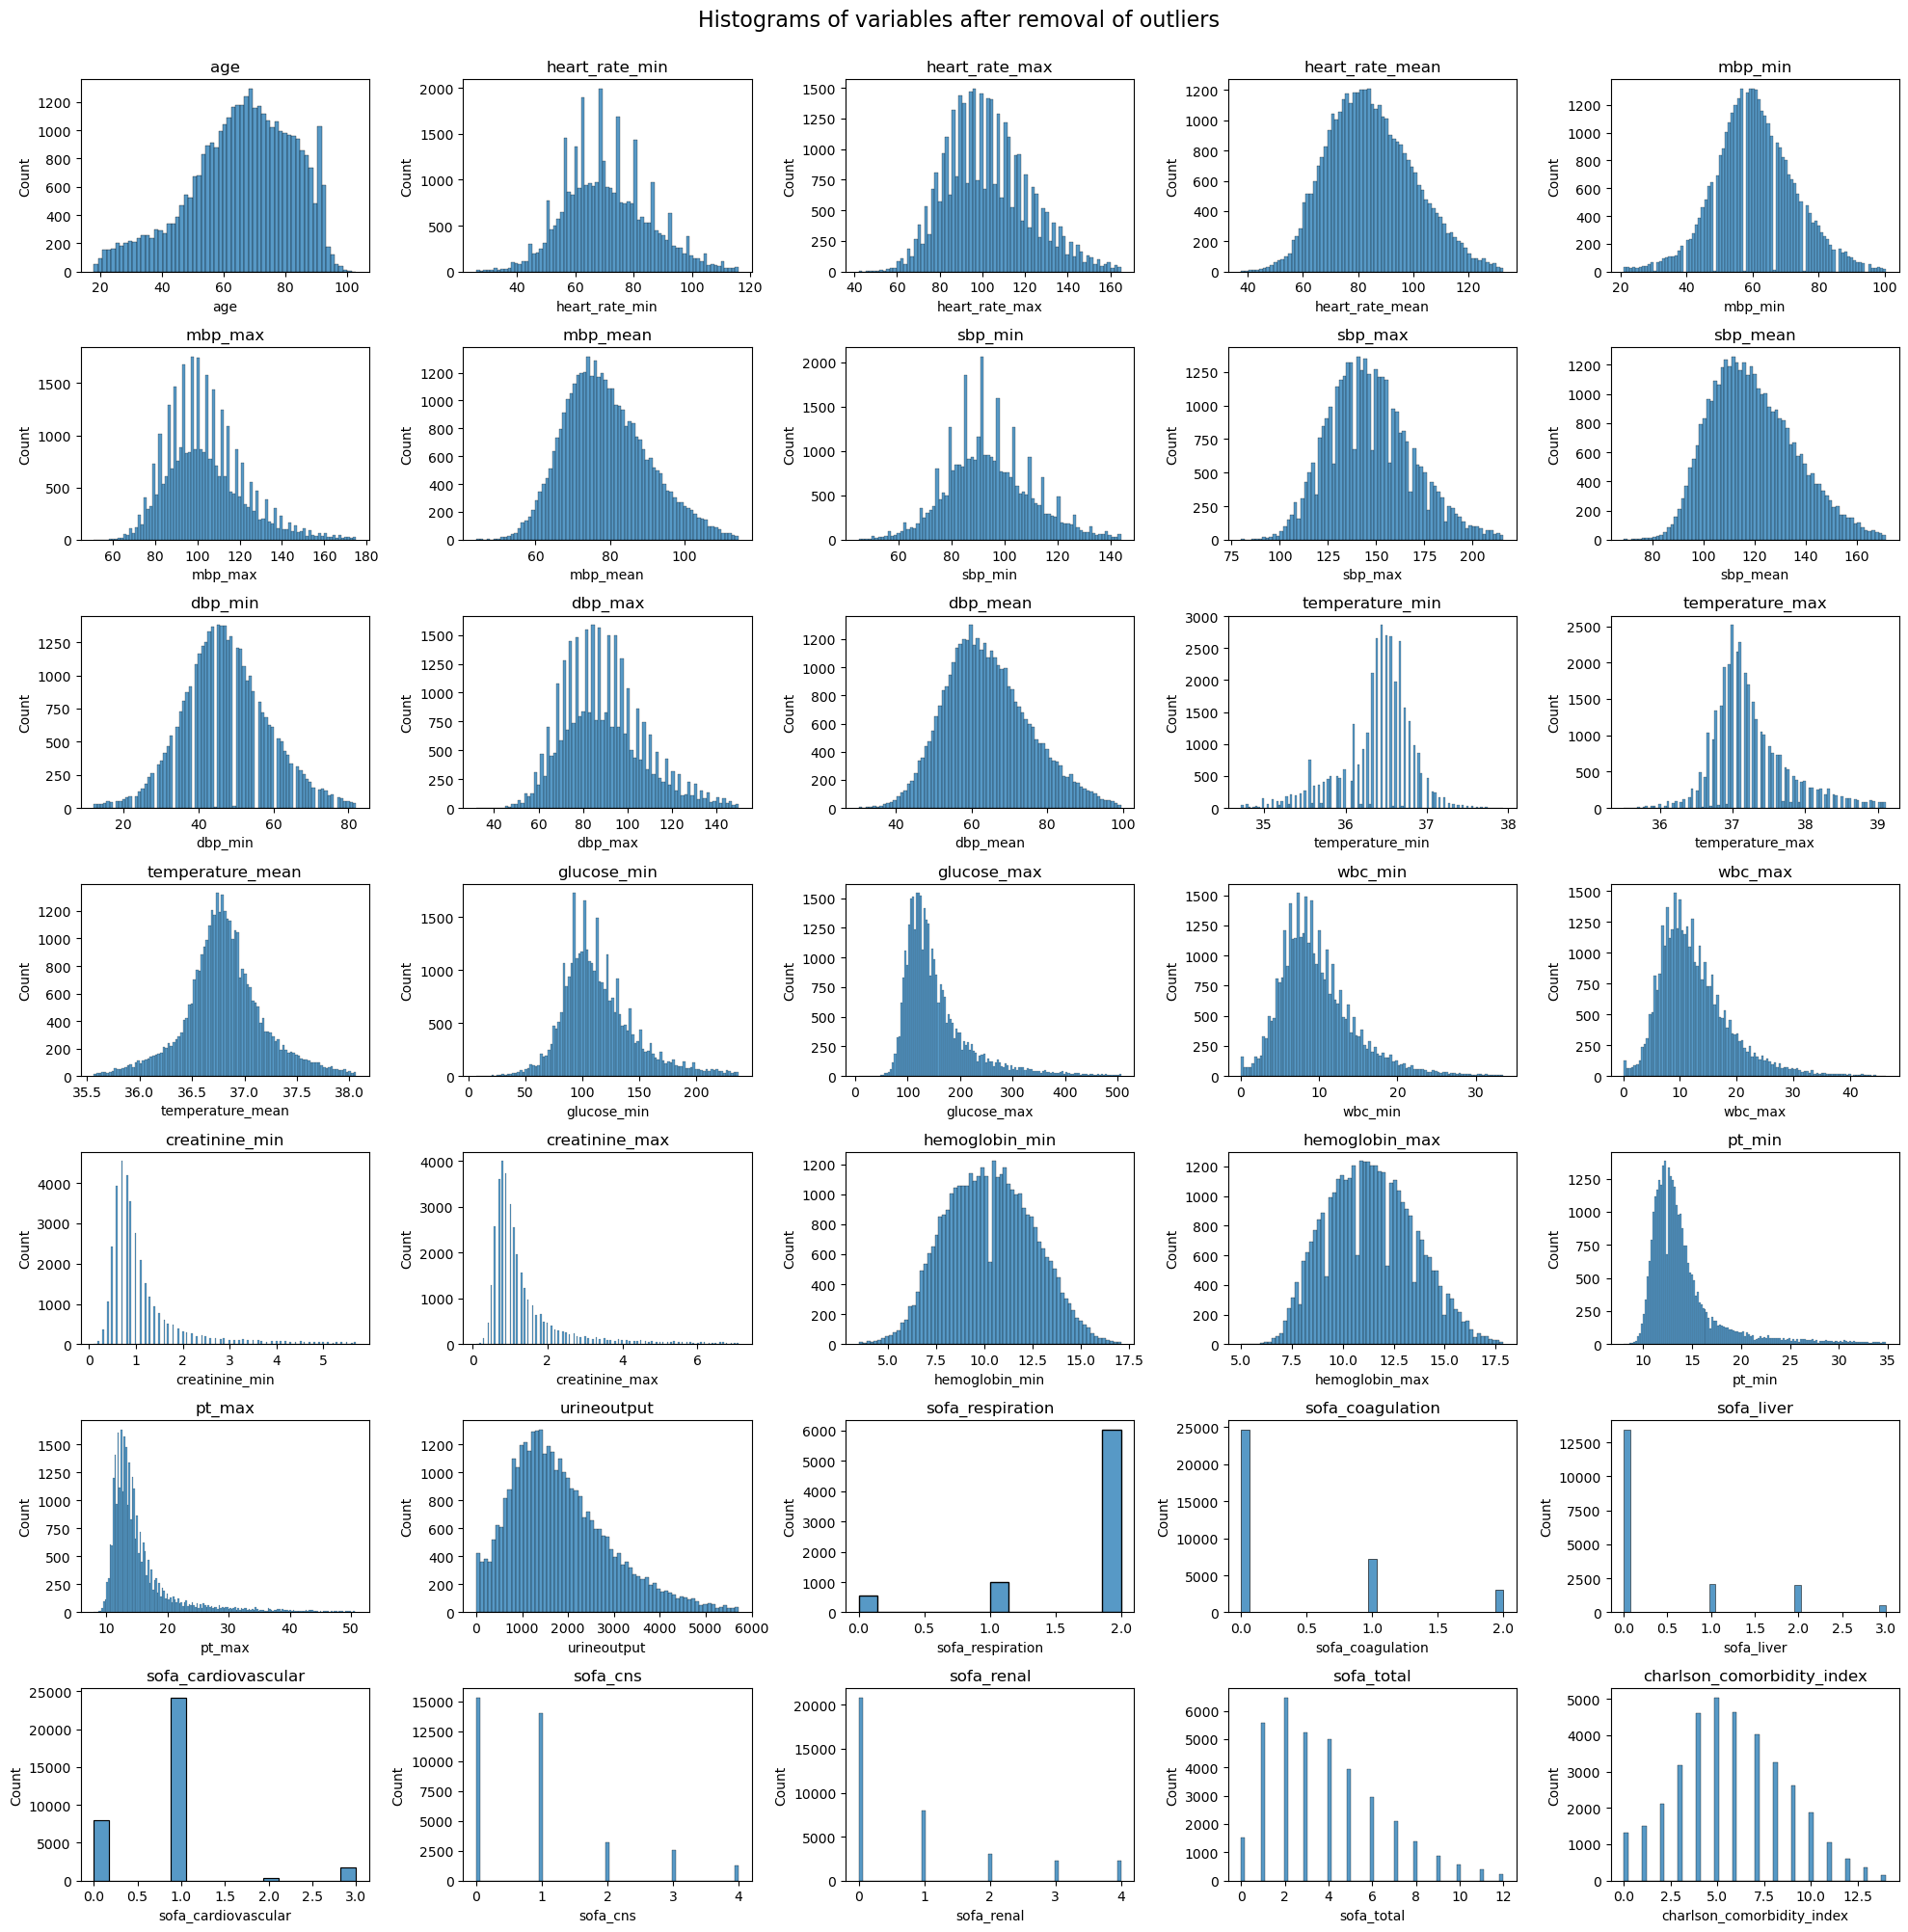

In [12]:
# 2.5.3 REVIEW DATA DISTRIBUTION AFTER REMOVAL OF OUTLIERS

# I want to check that the distribtion of the variables are not skewed after removal of outliers.
# Just by eyeballing, there is no difference in this plot and the previous plot in section 2.4.1

# plot separate boxplots for each variable in columns 1-32 (minus outcome) in a grid
fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(20, 20))
fig.suptitle('Histograms of variables after removal of outliers', fontsize=16, y=1.0)
fig.subplots_adjust(hspace=0.5, wspace=0.5) #adjust space between the plots
for i, ax in enumerate(axes.flatten()):
    if i < 35:
        sns.histplot(x=variable[i], data=data_2, ax=ax,palette='Set2')
        ax.set_title(variable[i])
        ax.set_xlabel(variable[i])
        ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

                                 age  heart_rate_min  heart_rate_max  \
age                         1.000000       -0.156446       -0.149303   
heart_rate_min             -0.156446        1.000000        0.661237   
heart_rate_max             -0.149303        0.661237        1.000000   
heart_rate_mean            -0.176984        0.895722        0.856208   
mbp_min                    -0.229374        0.059291        0.034453   
mbp_max                    -0.004907        0.015623        0.108227   
mbp_mean                   -0.206592        0.065619        0.106009   
sbp_min                    -0.103949       -0.036897       -0.081745   
sbp_max                     0.098156       -0.095761       -0.011414   
sbp_mean                    0.013782       -0.087310       -0.066844   
dbp_min                    -0.317459        0.143978        0.123452   
dbp_max                    -0.046797        0.079971        0.165238   
dbp_mean                   -0.313109        0.181207        0.21

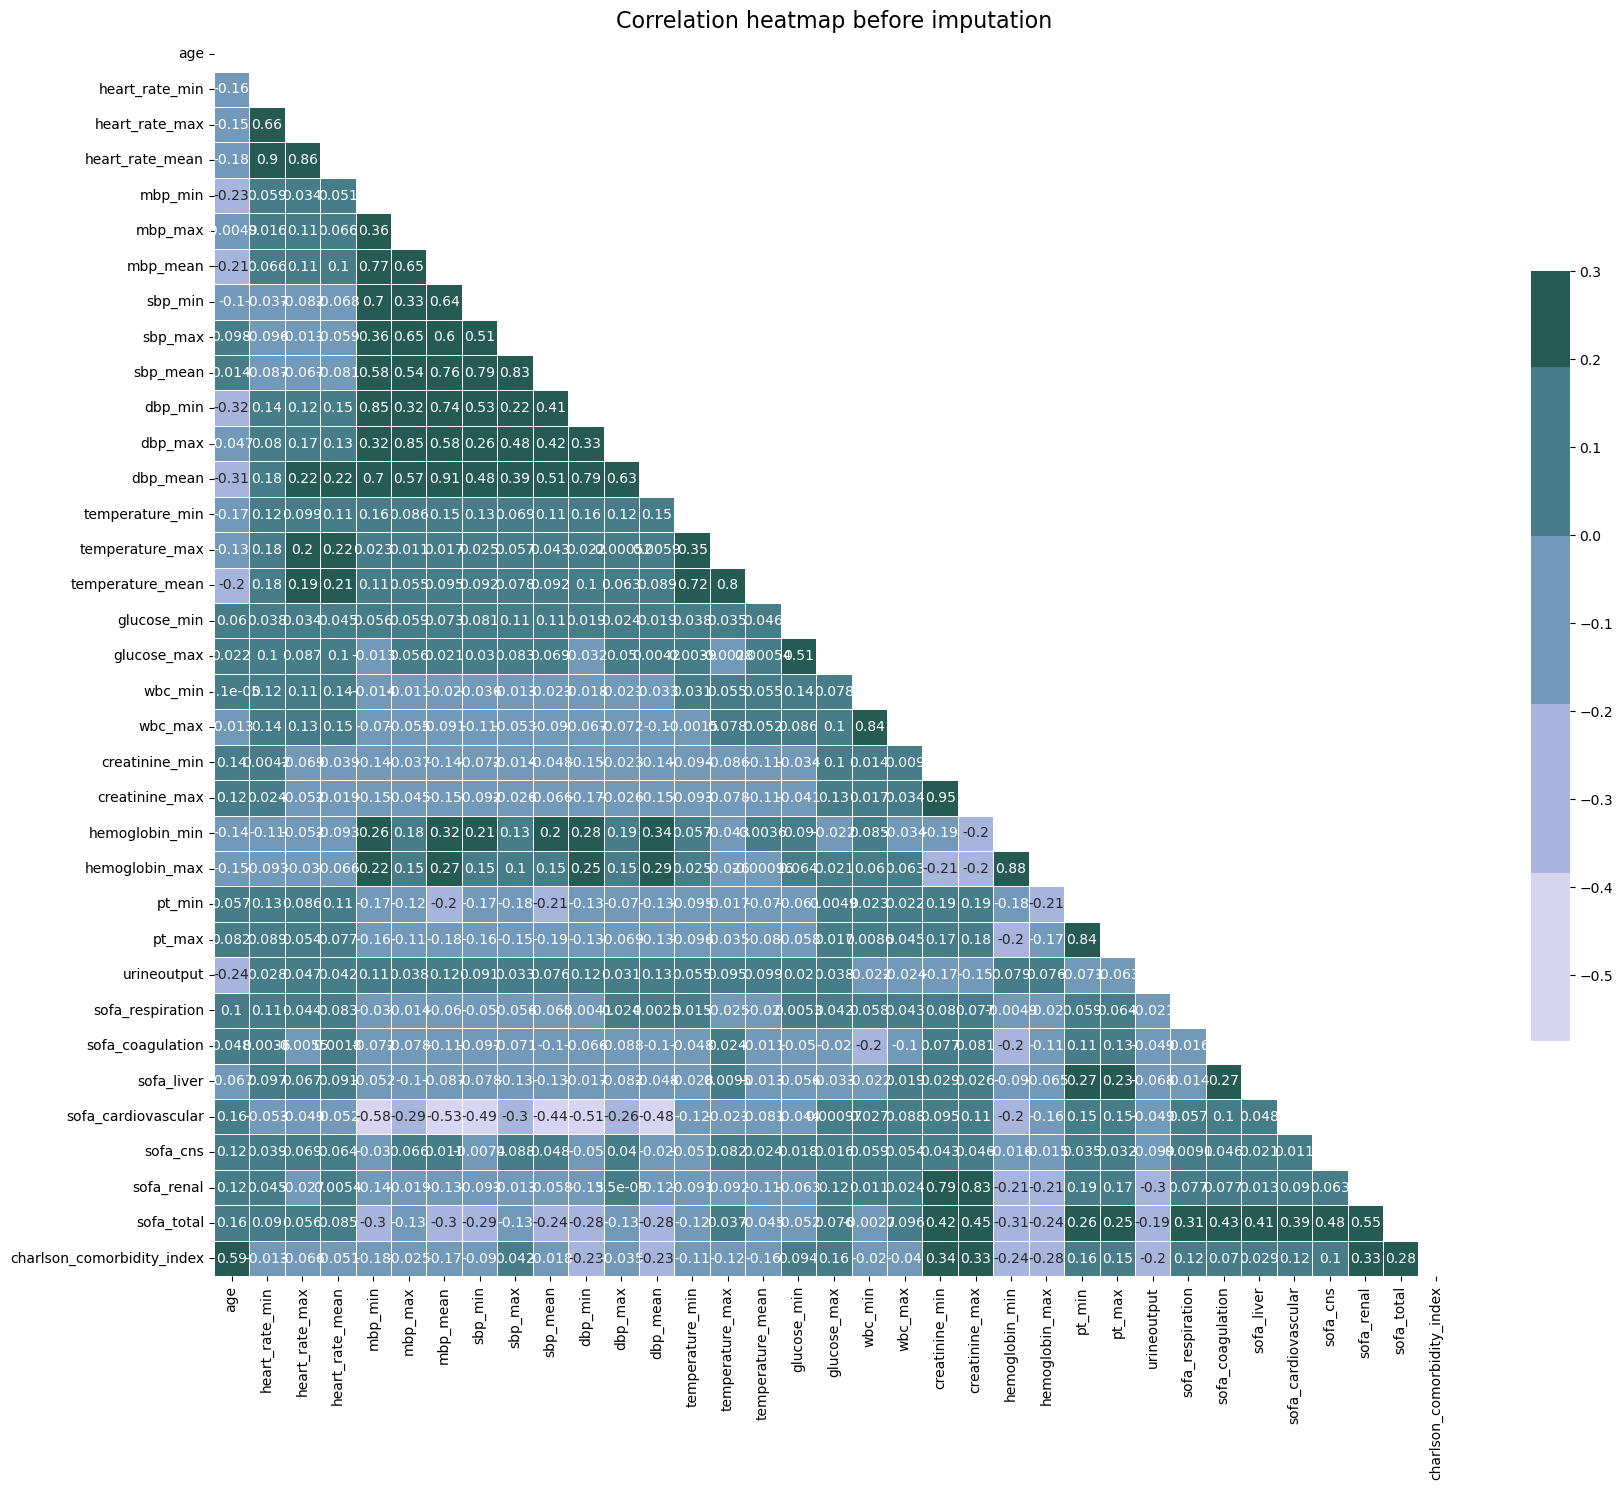

In [13]:
# 2.5.4 REVIEW CORRELATION OF THE VARIABLES BEFORE IMPUTATION

# Define variables to plot using heatmap
variable = data_2.loc[:, 'age':'charlson_comorbidity_index'].columns

# Correlation of variables before imputation
corr = data_2[variable].corr()
print(corr)

# Identify variables with high correlation
high_corr = np.where(corr > 0.8)
high_corr_vars = [(corr.columns[x], corr.columns[y]) for x, y in zip(*high_corr) if x != y]

print("Variables with correlation > 0.8:\n", high_corr_vars)

# hide upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# generate a custom diverging colormap
cmap = sns.cubehelix_palette(start=2)

# draw the heatmap with the mask and correct aspect ratio
plt.title('Correlation heatmap before imputation', fontsize=16, y=1.0)
sns.heatmap(corr, mask=mask, annot=True, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

### 2.6. IMPUTE MISSING VALUE

In [14]:
# 2.6.1 IMPUTE MISSING VALUES USING LINEAR REGRESSION 

data_imputed = data_2.copy()

# specify x and y variables. We want to impute missing values in x 
x = data_imputed.columns[1:36]
y = data_imputed.columns[36]
print(x)
print(y)

# impute missing values in x using IterativeImputer
imputer = IterativeImputer(max_iter=1000, random_state=0)
data_imputed[x] = imputer.fit_transform(data_imputed[x])

# convert data_imputed to a dataframe
data_imputed = pd.DataFrame(data_imputed)

# check for missing values
print(data_imputed.isnull().sum())

Index(['age', 'heart_rate_min', 'heart_rate_max', 'heart_rate_mean', 'mbp_min',
       'mbp_max', 'mbp_mean', 'sbp_min', 'sbp_max', 'sbp_mean', 'dbp_min',
       'dbp_max', 'dbp_mean', 'temperature_min', 'temperature_max',
       'temperature_mean', 'glucose_min', 'glucose_max', 'wbc_min', 'wbc_max',
       'creatinine_min', 'creatinine_max', 'hemoglobin_min', 'hemoglobin_max',
       'pt_min', 'pt_max', 'urineoutput', 'sofa_respiration',
       'sofa_coagulation', 'sofa_liver', 'sofa_cardiovascular', 'sofa_cns',
       'sofa_renal', 'sofa_total', 'charlson_comorbidity_index'],
      dtype='object')
outcome
gender                        0
age                           0
heart_rate_min                0
heart_rate_max                0
heart_rate_mean               0
mbp_min                       0
mbp_max                       0
mbp_mean                      0
sbp_min                       0
sbp_max                       0
sbp_mean                      0
dbp_min                       0
d

### 2.7. UNIVARIATE ANALYSIS AFTER IMPUTATION

In [15]:
# 2.7.1 CREATE TABLEONE TO GET AN OVERVIEW OF THE DATESET AFTER IMPUTATION 

# Perform univariate analysis between features and outcomes

columns = ['gender','age','heart_rate_min', 'heart_rate_max', 'heart_rate_mean', 'mbp_min', 'mbp_max', 'mbp_mean', 'sbp_min',
    'sbp_max', 'sbp_mean', 'dbp_min', 'dbp_max', 'dbp_mean', 'temperature_min', 'temperature_max', 'temperature_mean',
    'glucose_min', 'glucose_max', 'wbc_min', 'wbc_max', 'creatinine_min', 'creatinine_max',
    'hemoglobin_min', 'hemoglobin_max',  'pt_min', 'pt_max', 'urineoutput', 
    'sofa_respiration', 'sofa_coagulation','sofa_liver', 'sofa_cardiovascular', 'sofa_cns', 'sofa_renal', 'sofa_total','charlson_comorbidity_index',
    'outcome']
categorical = ['gender']
nonnormal = ['age', 'charlson_comorbidity_index', 'creatinine_max', 'creatinine_min', 
     'dbp_max', 'dbp_mean', 'dbp_min', 'glucose_max', 'glucose_min', 'heart_rate_max', 'heart_rate_mean', 'heart_rate_min', 
     'hemoglobin_max', 'hemoglobin_min', 'mbp_max', 'mbp_mean', 'mbp_min', 'pt_max', 'pt_min', 'sbp_max', 'sbp_mean', 'sbp_min', 
     'sofa_cardiovascular', 'sofa_cns', 'sofa_coagulation', 'sofa_liver', 'sofa_renal', 'sofa_respiration', 'sofa_total', 'temperature_max', 
     'temperature_mean', 'temperature_min', 'urineoutput', 'wbc_max', 'wbc_min',]
groupby=['outcome']

def normal_test(x):
     stat, p = shapiro(x)
     return p

table3 = TableOne(data_imputed, columns=columns, categorical=categorical,nonnormal=nonnormal, groupby=groupby, pval=True, missing=True, 
     normal_test=normal_test, tukey_test=True, htest_name=True)
print(table3.tabulate(tablefmt="github"))
table3.to_excel('table3.xlsx', sheet_name='table3') #save table to excel

print(table3)

|                                            |    | Missing   | Overall                | 0                      | 1                     | P-Value   | Test           |
|--------------------------------------------|----|-----------|------------------------|------------------------|-----------------------|-----------|----------------|
| n                                          |    |           | 36489                  | 35160                  | 1329                  |           |                |
| gender, n (%)                              | 0  | 0         | 16609 (45.5)           | 16079 (45.7)           | 530 (39.9)            | <0.001    | Chi-squared    |
|                                            | 1  |           | 19880 (54.5)           | 19081 (54.3)           | 799 (60.1)            |           |                |
| age, median [Q1,Q3]                        |    | 0         | 67.4 [55.5,78.7]       | 67.4 [55.5,78.8]       | 67.3 [56.3,76.7]      | 0.187     | Kruskal-Wallis 

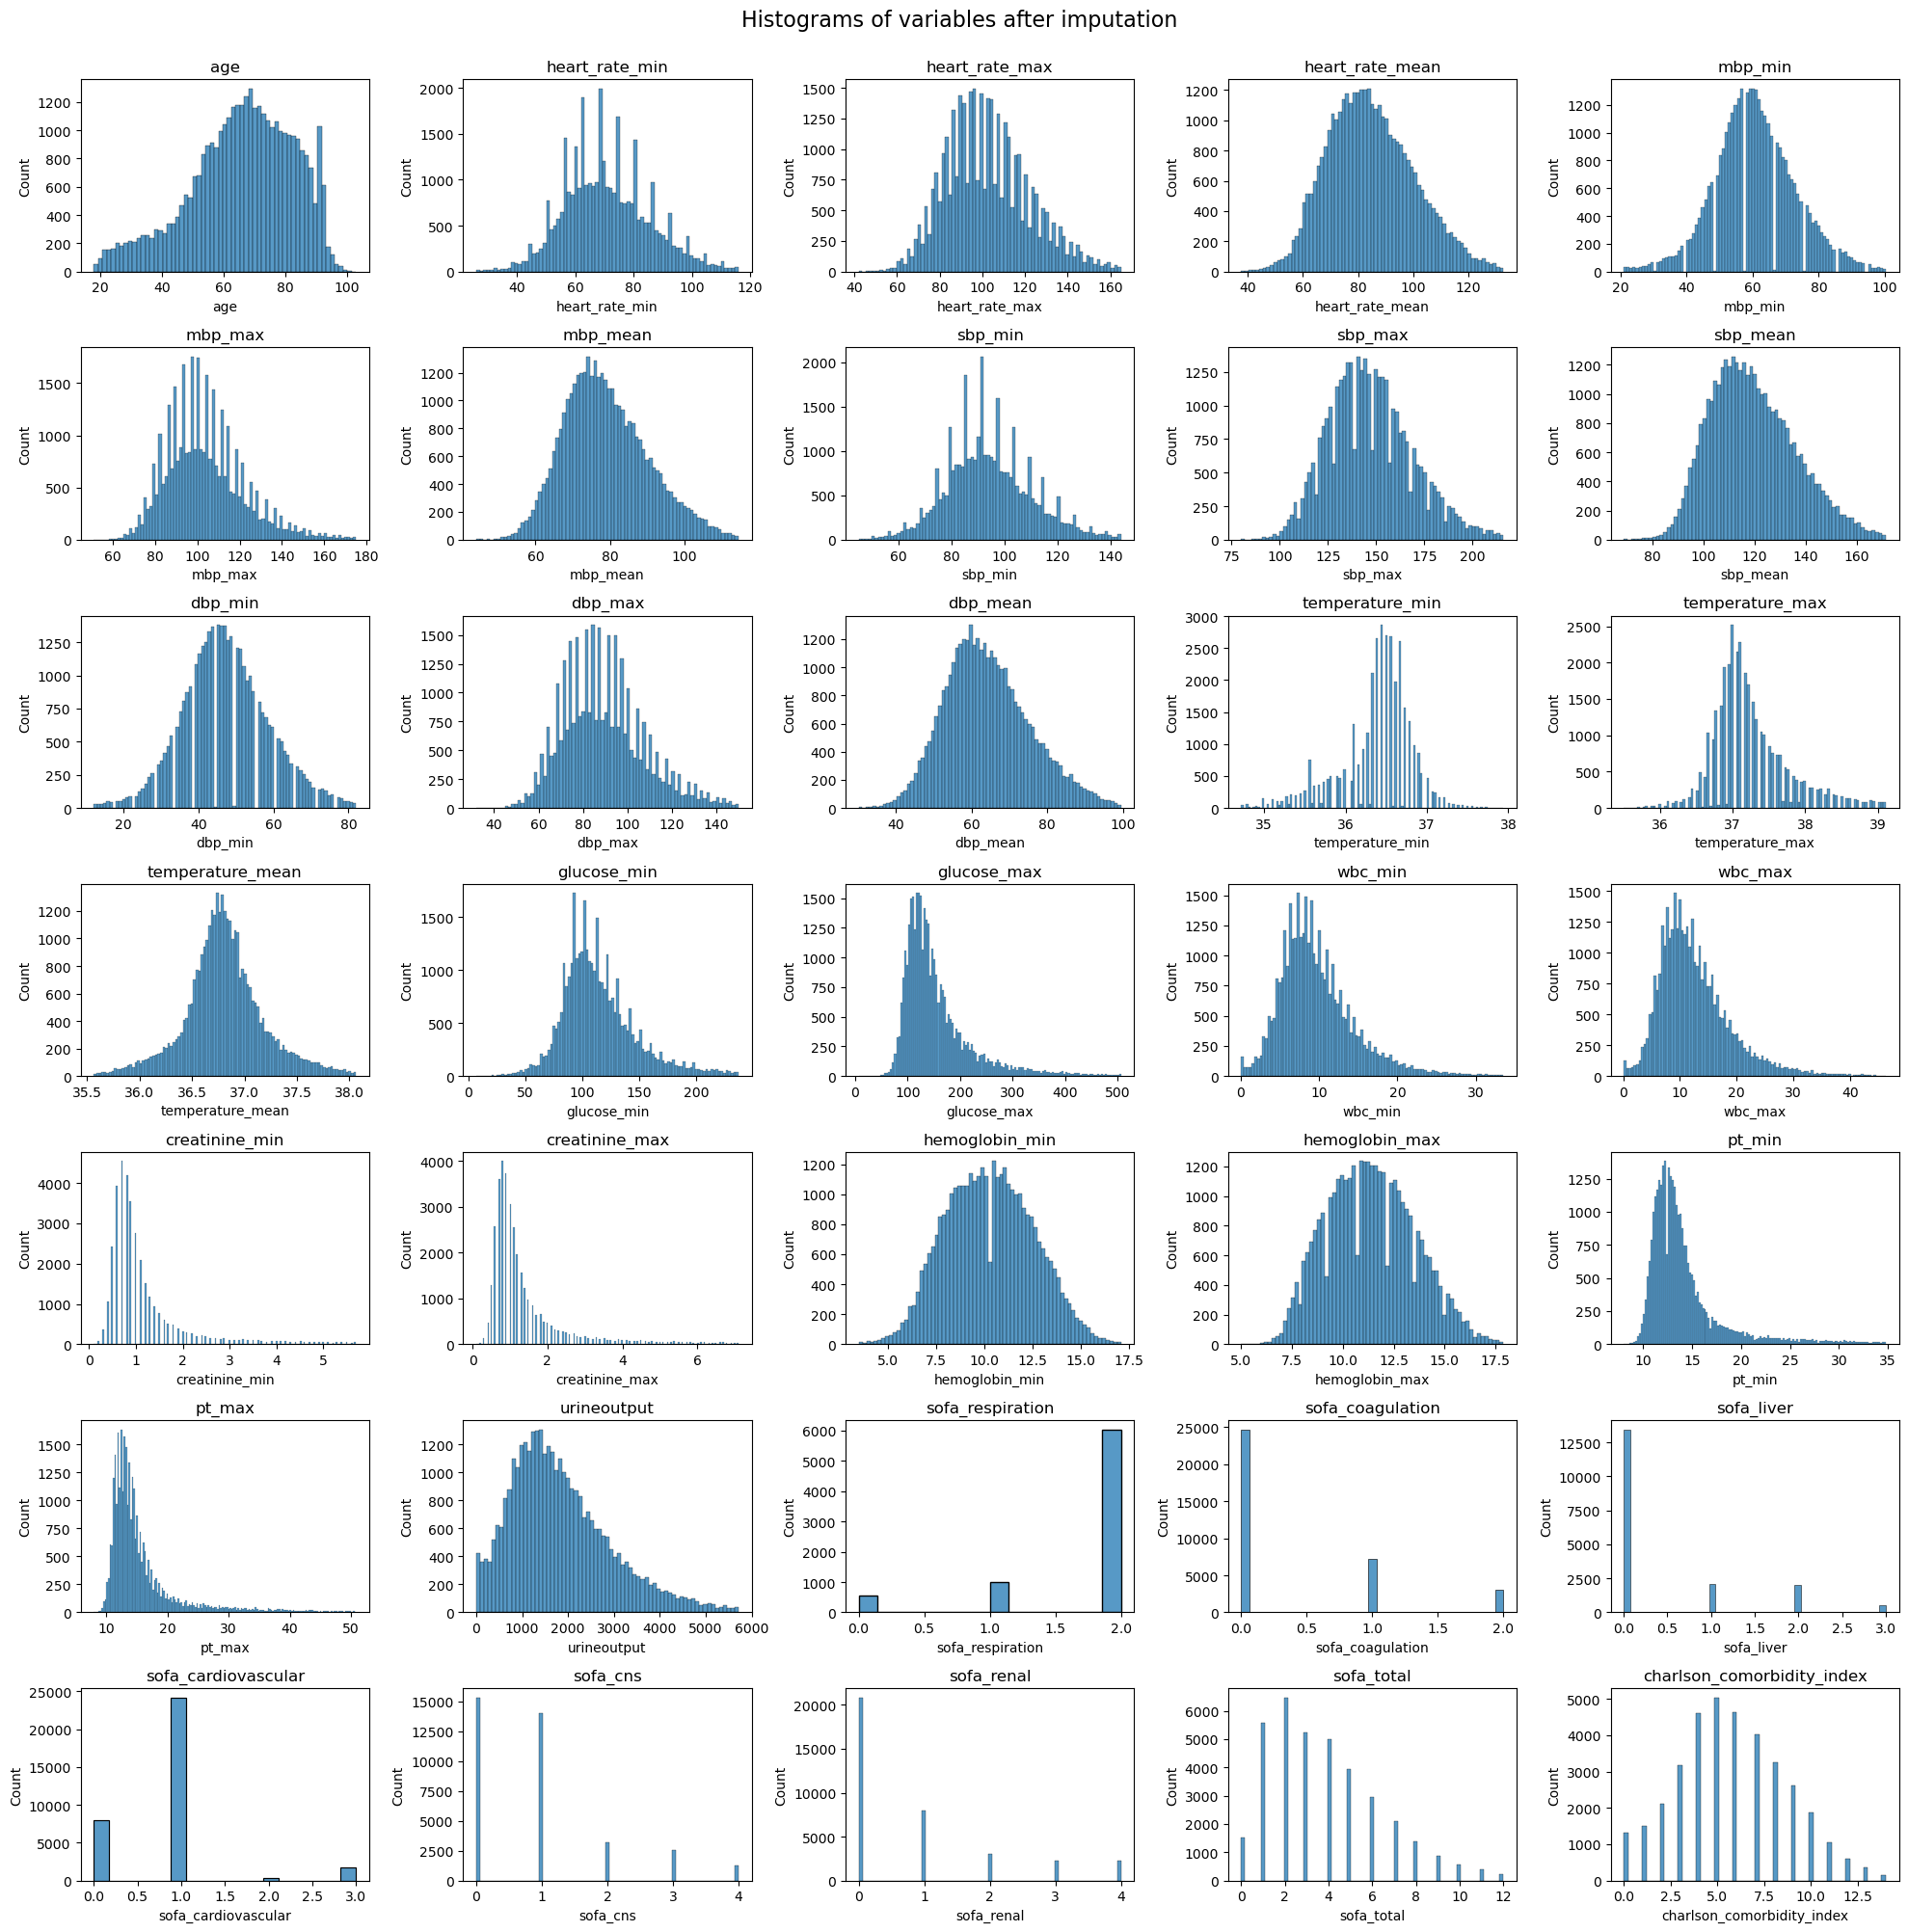

In [16]:
# 2.7.2 OVERVIEW OF THE DATA DISTRIBUTION AFTER IMPUTATION 

# Histograms of variables were plotted after imputation was performed. 

# specify x variables to plot using boxplots
variable = data_imputed.loc[:, 'age':'charlson_comorbidity_index'].columns

# plot separate histograms for each variable in columns 1-32 (minus outcome) in a grid
fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(20, 20))
fig.suptitle('Histograms of variables after imputation', fontsize=16, y=1.0)
fig.subplots_adjust(hspace=0.5, wspace=0.5) #adjust space between the plots
for i, ax in enumerate(axes.flatten()):
    if i < 35:
        sns.histplot(x=variable[i], data=data_2, ax=ax,palette='Set2')
        ax.set_title(variable[i])
        ax.set_xlabel(variable[i])
        ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

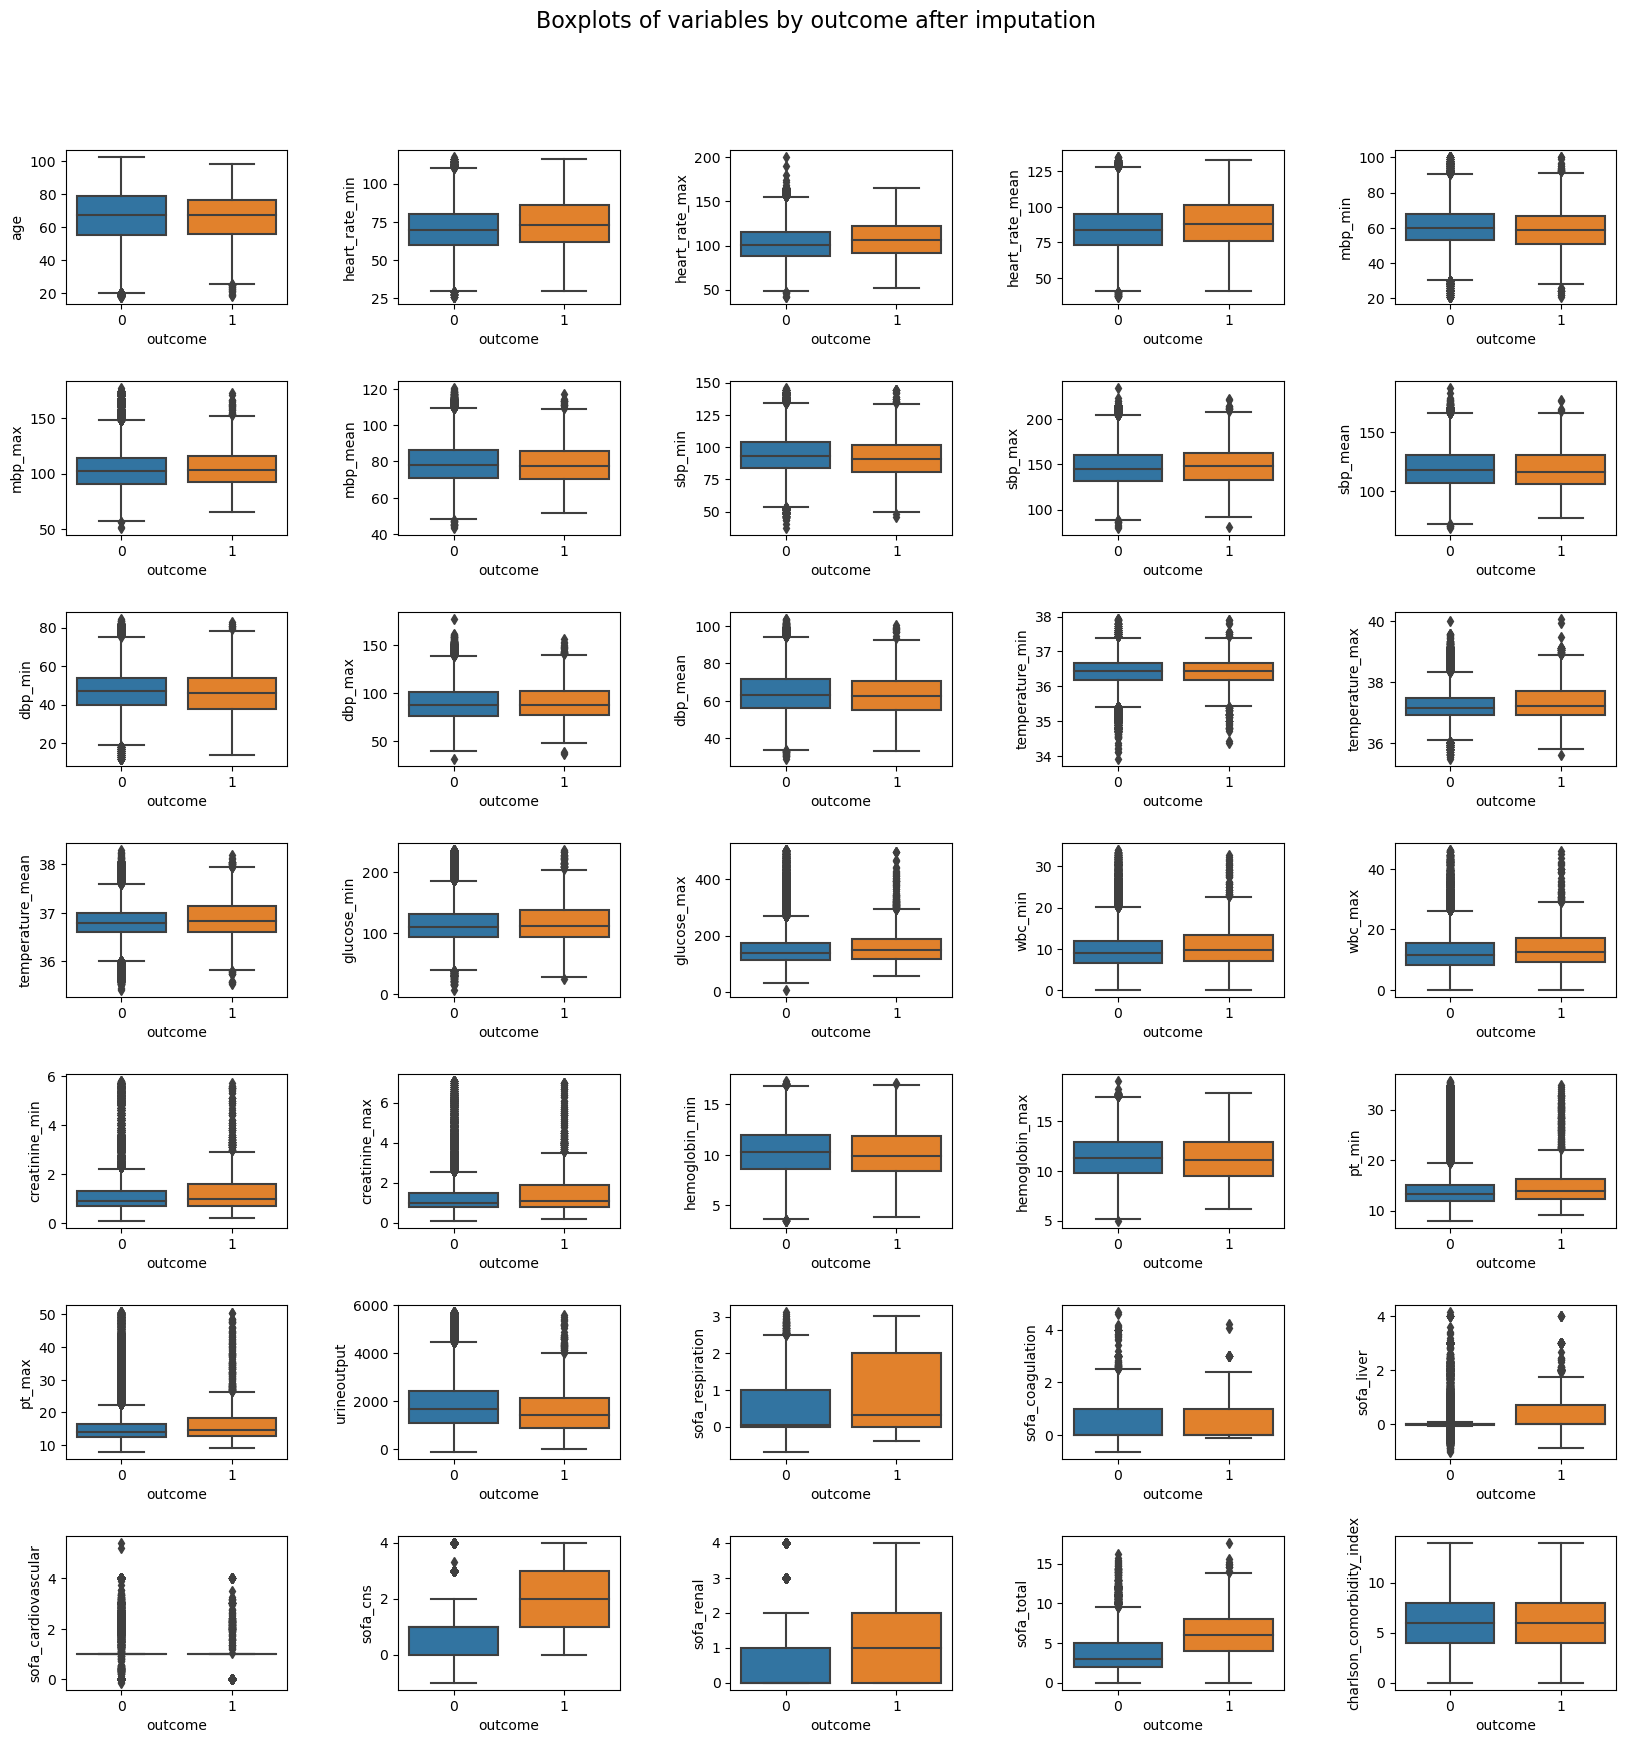

In [17]:
# 2.7.3 ASSESS FOR MEDIAN, 25TH AND 75TH PERCENTILES OF EACH VARIABLE BY OUTCOME

# plot boxplots for each variable by outcome in a grid
fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(20, 20))
fig.suptitle('Boxplots of variables by outcome after imputation', fontsize=16, y=0.95)
fig.subplots_adjust(hspace=0.5, wspace=0.5) #adjust space between the plots

count = 0
for var in variable:
    count += 1
    plt.subplot(7, 5, count)
    ax = sns.boxplot(x='outcome', y=var, data=data_imputed)
    
plt.show()

                                 age  heart_rate_min  heart_rate_max  \
age                         1.000000       -0.161215       -0.147888   
heart_rate_min             -0.161215        1.000000        0.662859   
heart_rate_max             -0.147888        0.662859        1.000000   
heart_rate_mean            -0.178181        0.899095        0.860572   
mbp_min                    -0.231953        0.060768        0.030732   
mbp_max                    -0.002724        0.016649        0.112200   
mbp_mean                   -0.215026        0.071423        0.106896   
sbp_min                    -0.103591       -0.037231       -0.089479   
sbp_max                     0.096320       -0.096707       -0.011153   
sbp_mean                    0.010976       -0.088736       -0.071602   
dbp_min                    -0.322968        0.149825        0.123299   
dbp_max                    -0.036829        0.080539        0.169319   
dbp_mean                   -0.321611        0.190463        0.22

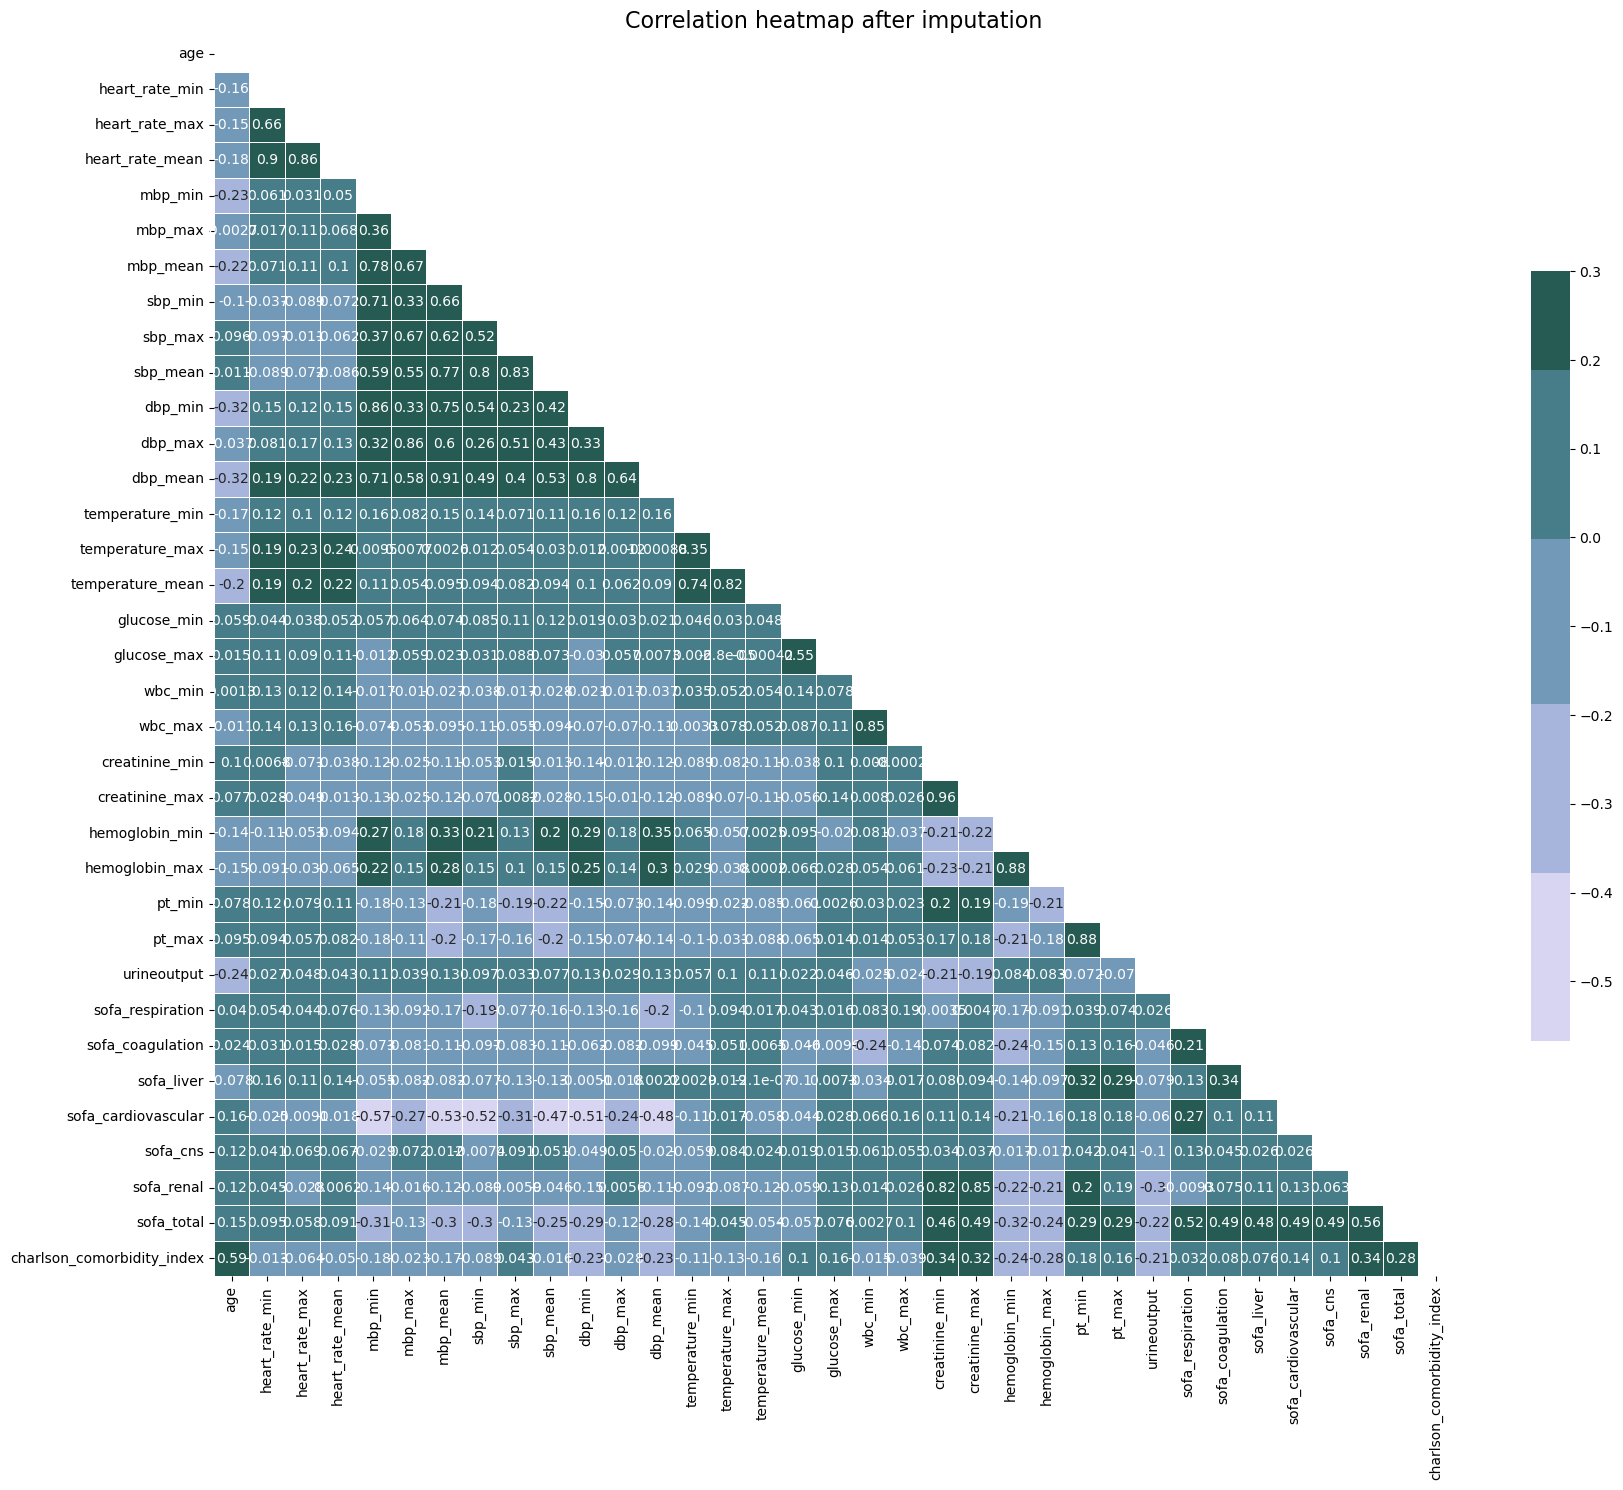

                             x           VIF
0                          age  3.106625e+01
1               heart_rate_min  1.806953e+02
2               heart_rate_max  1.628440e+02
3              heart_rate_mean  4.825642e+02
4                      mbp_min  2.221578e+02
5                      mbp_max  2.373226e+02
6                     mbp_mean  1.593251e+03
7                      sbp_min  1.660804e+02
8                      sbp_max  2.505296e+02
9                     sbp_mean  6.944625e+02
10                     dbp_min  1.209727e+02
11                     dbp_max  1.526997e+02
12                    dbp_mean  7.845020e+02
13             temperature_min  2.850008e+04
14             temperature_max  2.678670e+04
15            temperature_mean  8.933056e+04
16                 glucose_min  2.188808e+01
17                 glucose_max  1.113819e+01
18                     wbc_min  2.403098e+01
19                     wbc_max  2.478566e+01
20              creatinine_min  3.888083e+01
21        

In [18]:
# 2.7.4 REVIEW CORRELATION OF THE VARIABLES AFTER IMPUTATION

# Correlation of variables after imputation
corr = data_imputed[variable].corr()
print(corr)

# Identify variables with high correlation
high_corr = np.where(corr > 0.8)
high_corr_vars = [(corr.columns[x], corr.columns[y]) for x, y in zip(*high_corr) if x != y]

print("Variables with correlation > 0.8:\n", high_corr_vars)

# hide upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# generate a custom diverging colormap
cmap = sns.cubehelix_palette(start=2)

# draw the heatmap with the mask and correct aspect ratio
plt.title('Correlation heatmap after imputation', fontsize=16, y=1.0)
sns.heatmap(corr, mask=mask, annot=True, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

# check correlation using vif
vif = pd.DataFrame()
vif["x"] = data_imputed[x].columns
vif["VIF"] = [variance_inflation_factor(data_imputed[x].values, i) for i in range(data_imputed[x].shape[1])]
print(vif)
vif.to_excel('vif.xlsx', sheet_name='vif') #save table to excel

In [19]:
# 2.7.5 REMOVE VARIABLES THAT WERE NOT STATISTISCALLY SIGNIFICANT IN THE UNIVARIATE ANALYSIS AND WERE HIGHLY CORRELATED WITH ONE ANOTHER

# Age was retained despite being not statisitcally significant as it is a well-known confounder. 

date_imputed_retained = data_imputed.copy()
date_imputed_retained=pd.DataFrame(date_imputed_retained)

# drop variables that were not statistically significant in the univariate analysis or highly correlated with one another
data_imputed_retained = date_imputed_retained.drop(['heart_rate_min', 'heart_rate_max', 'mbp_min', 'mbp_mean', 'mbp_max', 
    'dbp_min', 'dbp_max', 'sbp_min', 'sbp_max', 'temperature_max', 'temperature_min', 'wbc_min', 'creatinine_min', 'hemoglobin_min', 'pt_min'], axis=1)

print(data_imputed_retained.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36489 entries, 0 to 36488
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   gender                      36489 non-null  int32  
 1   age                         36489 non-null  float64
 2   heart_rate_mean             36489 non-null  float64
 3   sbp_mean                    36489 non-null  float64
 4   dbp_mean                    36489 non-null  float64
 5   temperature_mean            36489 non-null  float64
 6   glucose_min                 36489 non-null  float64
 7   glucose_max                 36489 non-null  float64
 8   wbc_max                     36489 non-null  float64
 9   creatinine_max              36489 non-null  float64
 10  hemoglobin_max              36489 non-null  float64
 11  pt_max                      36489 non-null  float64
 12  urineoutput                 36489 non-null  float64
 13  sofa_respiration            364

In [20]:
# 2.7.6 CHECK FOR MULTICOLLINEARITY

variable = data_imputed_retained.loc[:, 'age':'charlson_comorbidity_index'].columns

vif = pd.DataFrame()
vif["x"] = data_imputed_retained[variable].columns
vif["VIF"] = [variance_inflation_factor(data_imputed_retained[variable].values, i) for i in range(data_imputed_retained[variable].shape[1])]
print(vif)



                             x           VIF
0                          age  3.032672e+01
1              heart_rate_mean  4.095778e+01
2                     sbp_mean  1.025469e+02
3                     dbp_mean  8.085255e+01
4             temperature_mean  3.661524e+02
5                  glucose_min  2.074078e+01
6                  glucose_max  1.040776e+01
7                      wbc_max  5.871728e+00
8               creatinine_max  9.645488e+00
9               hemoglobin_max  3.631484e+01
10                      pt_max  9.200572e+00
11                 urineoutput  4.872334e+00
12            sofa_respiration  1.585775e+13
13            sofa_coagulation  1.098439e+13
14                  sofa_liver  8.410083e+12
15         sofa_cardiovascular  2.523025e+13
16                    sofa_cns  3.275345e+13
17                  sofa_renal  3.588526e+13
18                  sofa_total  3.753000e+14
19  charlson_comorbidity_index  9.228336e+00


### 2.8. DATA SUMMARY OF OUTCOME AND FEATURES

In [21]:
# 2.8.1 SUMMARISE DATA TO GET AN OVERVIEW OF THE DATASET

# find total number of patients in the dataset
len(data_imputed_retained.index)
print('number of ICU patients: ' + str(len(data_imputed_retained.index.unique())))

# number of patients with and without intubation 
number_intubated = data_imputed_retained['outcome'].value_counts().sort_index().tolist()
print(number_intubated)
print('number of ICU patients intubated: ' + str(len(data_imputed_retained[data_imputed_retained['outcome']==1].index.unique())))
print('number of ICU patients not intubated: ' + str(len(data_imputed_retained[data_imputed_retained['outcome']==0].index.unique())))

# number of features
print('number of features including outcome: ' + str(len(data_imputed_retained.columns)))

number of ICU patients: 36489
[35160, 1329]
number of ICU patients intubated: 1329
number of ICU patients not intubated: 35160
number of features including outcome: 22


## **3. RUN THE MODELS**

### 3.1. SPLIT DATASET INTO TEST AND TRAIN

In [67]:
# 3.1.1 SPLIT THE DATA INTO TRAINING AND TEST SETS, STANDARDISE THE DATA AND BALANCE THE DATASET

# specify x and y variables
x=data_imputed_retained.drop(['outcome'], axis=1)
#print(x)
y=data_imputed_retained['outcome']
#print(y)

# Do the 70-30 split

test_size = 0.3
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = test_size, random_state = 0)  

# Count the number of samples with and without the outcome variable in the training set
train_outcome_count = y_train.value_counts()
train_outcome_count.index = ['No Outcome', 'Outcome']
print('Training set:')
print(train_outcome_count)

# Count the number of samples with and without the outcome variable in the testing set
test_outcome_count = y_test.value_counts()
test_outcome_count.index = ['No Outcome', 'Outcome']
print('Testing set:')
print(test_outcome_count)

# concatenate the x and y datasets for train and tests
train_data = pd.concat([x_train, y_train], axis=1)
test_data = pd.concat([x_test, y_test], axis=1)

# 3.1.2 Do normalisation and smote for the train data and test data

pipetrain = imbpipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(sampling_strategy='minority'))
])

# fit the pipeline to the train data
x_train_smote, y_train_smote = pipetrain.fit_resample(x_train, y_train)
#print(x_train_smote)
#print(y_train_smote)

# check y values before and after smote
before_smote = y_train.value_counts()
after_smote = y_train_smote.value_counts()
print('Values before SMOTE: {}'.format(before_smote))
print('Values after SMOTE: {}'.format(after_smote))

# do normalisation only for the test data
scaler = StandardScaler()
x_test = scaler.fit_transform(x_test)

Training set:
No Outcome    24608
Outcome         934
Name: outcome, dtype: int64
Testing set:
No Outcome    10552
Outcome         395
Name: outcome, dtype: int64
Values before SMOTE: 0    24608
1      934
Name: outcome, dtype: int64
Values after SMOTE: 0    24608
1    24608
Name: outcome, dtype: int64


In [69]:
# 3.1.3 DESCRIPTIVE STATISTICS OF THE TRAINING AND TEST SETS

# do descriptive statistics for the training and test sets
columns = ['gender','age', 'heart_rate_mean',  'sbp_mean', 'dbp_mean', 'temperature_mean','glucose_min', 'glucose_max', 'wbc_max', 'creatinine_max',
   'hemoglobin_max',   'pt_max', 'urineoutput', 'sofa_respiration', 'sofa_coagulation','sofa_liver', 'sofa_cardiovascular', 'sofa_cns', 'sofa_renal', 'sofa_total','charlson_comorbidity_index' ]
categorical = ['gender']
nonnormal = ['age', 'heart_rate_mean',  'sbp_mean', 'dbp_mean', 'temperature_mean','glucose_min', 'glucose_max', 'wbc_max', 'creatinine_max',
    'hemoglobin_max',   'pt_max', 'urineoutput', 'sofa_respiration', 'sofa_coagulation','sofa_liver', 'sofa_cardiovascular', 'sofa_cns', 'sofa_renal', 'sofa_total','charlson_comorbidity_index']
groupby=['outcome']

def normal_test(x):
     stat, p = shapiro(x)
     return p

table4 = TableOne(train_data, columns=columns, categorical=categorical,nonnormal=nonnormal, groupby=groupby, pval=True, missing=True, 
     normal_test=normal_test, tukey_test=True, htest_name=True)
print(table4.tabulate(tablefmt="github"))
table4.to_excel('table4.xlsx', sheet_name='table4') #save table to excel

table5 = TableOne(test_data, columns=columns, categorical=categorical,nonnormal=nonnormal, groupby=groupby, pval=True, missing=True, 
     normal_test=normal_test, tukey_test=True, htest_name=True)
print(table5.tabulate(tablefmt="github"))
table5.to_excel('table5.xlsx', sheet_name='table5') #save table to excel

|                                            |    | Missing   | Overall                | 0                      | 1                     | P-Value   | Test           |
|--------------------------------------------|----|-----------|------------------------|------------------------|-----------------------|-----------|----------------|
| n                                          |    |           | 25542                  | 24608                  | 934                   |           |                |
| gender, n (%)                              | 0  | 0         | 11586 (45.4)           | 11208 (45.5)           | 378 (40.5)            | 0.002     | Chi-squared    |
|                                            | 1  |           | 13956 (54.6)           | 13400 (54.5)           | 556 (59.5)            |           |                |
| age, median [Q1,Q3]                        |    | 0         | 67.5 [55.6,78.7]       | 67.5 [55.6,78.8]       | 67.9 [56.5,77.5]      | 0.787     | Kruskal-Wallis 

### 3.2. LOGISTIC REGRESSION - FULL , STEPWISE SELECTION WITH L2 REGULARISATION    

In [29]:
# 3.2.1 PERFORM FEATURE SELECTION - FORWARD AND BACKWARD SELECTION

# tried c values of 0.0001 0.01, 0.1, 1, 10, 100, 1000

# specify the model
lr = logit(penalty='l2',C=1/100,solver='liblinear') # c: 1/(strength of L2 regularization)

# forward selection
forward_selection = sfs(lr, direction="forward", scoring='roc_auc', cv=5).fit(x_train_smote, y_train_smote)
selected_feature_mask = forward_selection.get_support()
selected_feature_names_fs = x.columns[selected_feature_mask]
print('Features from forward selection lr: {}'.format(selected_feature_names_fs))

# backward selection 
backward_selection = sfs(lr, direction="backward", scoring='roc_auc', cv=5).fit(x_train_smote, y_train_smote)
selected_feature_mask = backward_selection.get_support()
selected_feature_names_bw = x.columns[selected_feature_mask]
print(selected_feature_names_bw)

Features from forward selection lr: Index(['gender', 'heart_rate_mean', 'glucose_min', 'urineoutput',
       'sofa_respiration', 'sofa_coagulation', 'sofa_liver',
       'sofa_cardiovascular', 'sofa_cns', 'sofa_renal'],
      dtype='object')
Index(['gender', 'heart_rate_mean', 'glucose_min', 'urineoutput',
       'sofa_respiration', 'sofa_coagulation', 'sofa_cns', 'sofa_renal',
       'sofa_total', 'charlson_comorbidity_index'],
      dtype='object')


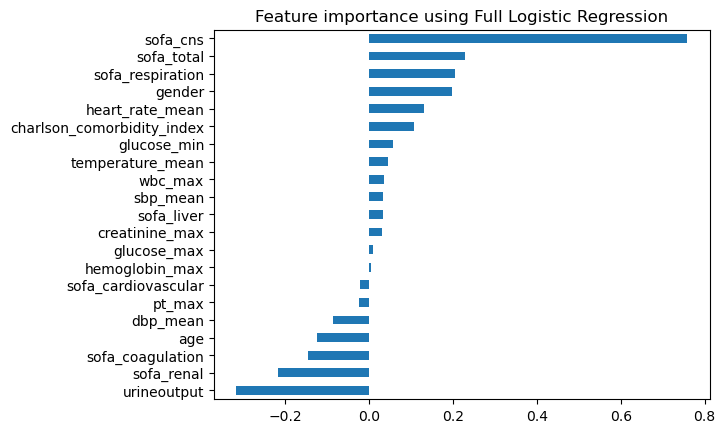

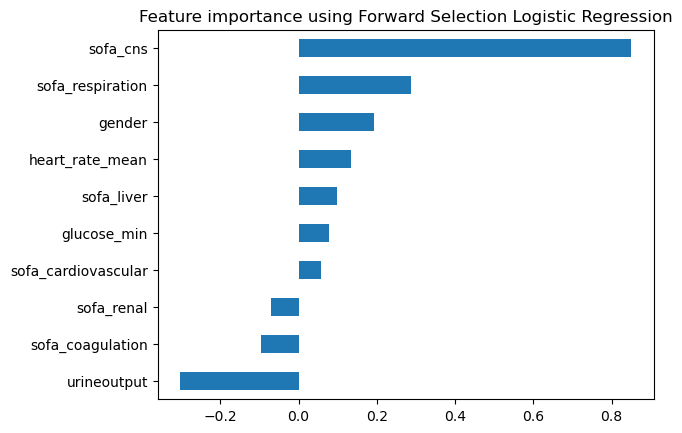

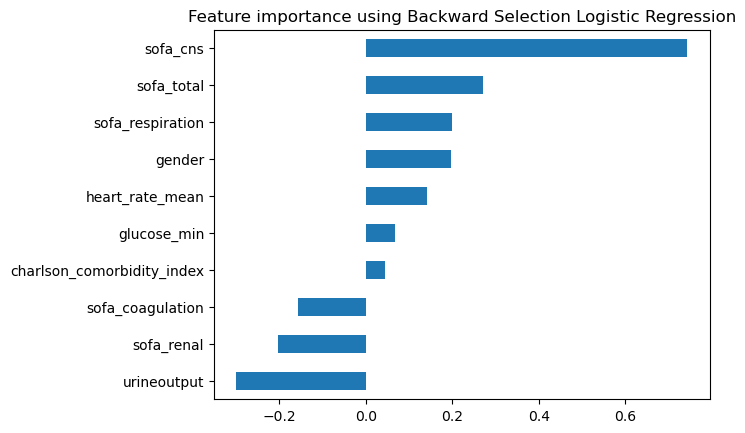

In [30]:
# 3.2.2 TRAIN AND TEST DATA ON FULL MODEL, FORWARD SELECTED MODEL AND BACKWARD SELECTED MODEL

# set threshold for the model
threshold = 0.6

# fit full lr
lr_full = lr.fit(x_train_smote,y_train_smote)
y_pred_pr_full = lr.predict_proba(x_test)[:, 1] # select probabilities for positive class
y_pred_full = (y_pred_pr_full >threshold).astype(int) # convert probabilities to class labels

# plot the important variables for the full model based on coefficients
coef_full = lr_full.coef_[0]
coef_full = pd.Series(coef_full, index = x.columns)
imp_coef = coef_full.sort_values()
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Full Logistic Regression")
plt.show()

# fit lr with forward selected features
lr_fs = lr.fit(forward_selection.transform(x_train_smote),y_train_smote)
y_pred_pr_fs = lr.predict_proba(forward_selection.transform(x_test))[:, 1] # select probabilities for positive class
y_pred_fs = (y_pred_pr_fs >threshold).astype(int) # convert probabilities to class labels

# plot the important variables for the forward selection model
coef_fs = lr_fs.coef_[0]
coef_fs = pd.Series(coef_fs, index = selected_feature_names_fs)
imp_coef = coef_fs.sort_values()
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Forward Selection Logistic Regression")
plt.show()

# fit lr with backward selected features
lr_bw = lr.fit(backward_selection.transform(x_train_smote),y_train_smote)
y_pred_pr_bw = lr.predict_proba(backward_selection.transform(x_test))[:, 1]
y_pred_bw = (y_pred_pr_bw >threshold).astype(int) # convert probabilities to class labels

# plot the important variables for the backward selection lr
coef_bw = lr_bw.coef_[0]
coef_bw = pd.Series(coef_bw, index = selected_feature_names_bw)
imp_coef = coef_bw.sort_values()
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Backward Selection Logistic Regression")
plt.show()

AUROC for full lr : 0.688
AUROC for lr with forward selection: 0.685
AUROC for lr with backward selection: 0.685
Recall for full lr : 0.685
Recall for lr with forward selection: 0.685
Recall for lr with backward selection: 0.685
Precision for full lr: 0.115
Precision for lr with forward selection: 0.114
Precision for lr with backward selection: 0.114
F1 for full lr: 0.189
F1 for lr with forward selection: 0.187
F1 for lr with backward selection: 0.187
AP for full lr: 0.078
AP for lr with forward selection: 0.077
AP for lr with backward selection: 0.076
Classification of full lr:
Predicted     0     1
Actual               
0          8953  1599
1           187   208

Classification of lr with forward selection:
Predicted     0     1
Actual               
0          8954  1598
1           189   206

Classification of lr with backward selection:
Predicted     0     1
Actual               
0          8944  1608
1           189   206

Accuracy for full lr: 0.837
Accuracy for lr with forward

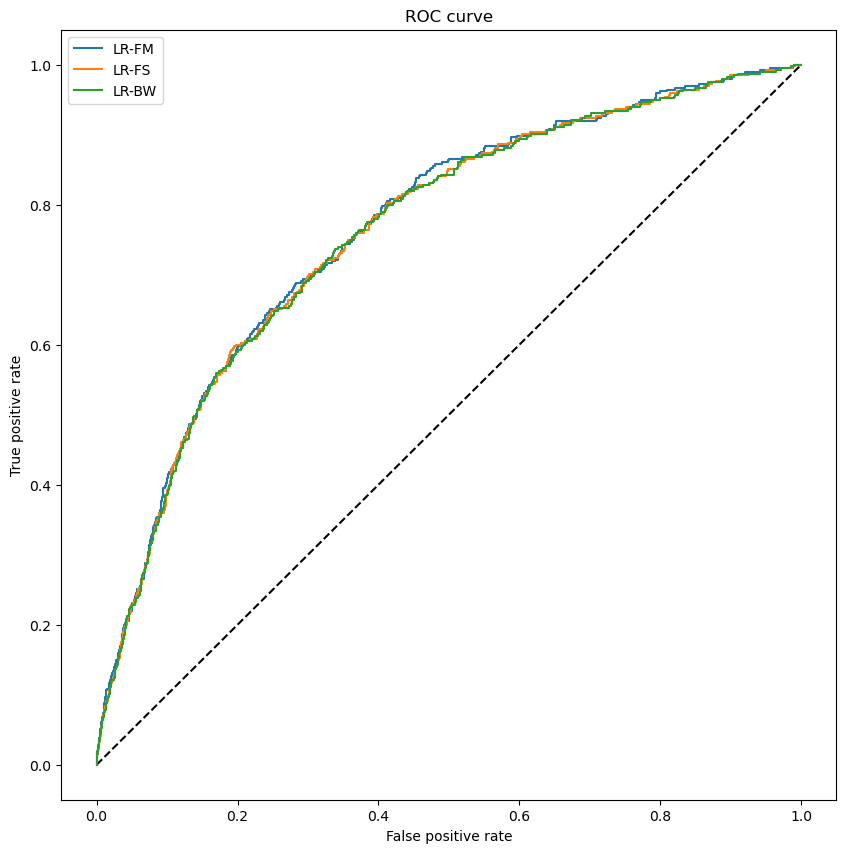

In [31]:
# 3.2.3 EVALUATE MODEL PERFORMANCE

# roc 
auroc = roc_auc_score(y_test, y_pred_full)
print('AUROC for full lr : {:.3f}'.format(auroc))

auroc = roc_auc_score(y_test, y_pred_fs)
print('AUROC for lr with forward selection: {:.3f}'.format(auroc))

auroc = roc_auc_score(y_test, y_pred_bw)
print('AUROC for lr with backward selection: {:.3f}'.format(auroc))

# recall
recall = recall_score(y_test, y_pred_full)
print('Recall for full lr : {:.3f}'.format(auroc))

recall = recall_score(y_test, y_pred_fs)
print('Recall for lr with forward selection: {:.3f}'.format(auroc))

recall = recall_score(y_test, y_pred_bw)
print('Recall for lr with backward selection: {:.3f}'.format(auroc))

# precision
precision = precision_score(y_test, y_pred_full.round())
print('Precision for full lr: {:.3f}'.format(precision))

precision = precision_score(y_test, y_pred_fs.round())
print('Precision for lr with forward selection: {:.3f}'.format(precision))

precision = precision_score(y_test, y_pred_bw.round())
print('Precision for lr with backward selection: {:.3f}'.format(precision))

# f1
f1 = f1_score(y_test, y_pred_full.round())
print('F1 for full lr: {:.3f}'.format(f1))

f1 = f1_score(y_test, y_pred_fs.round())
print('F1 for lr with forward selection: {:.3f}'.format(f1))

f1 = f1_score(y_test, y_pred_bw.round())
print('F1 for lr with backward selection: {:.3f}'.format(f1))

# ap
ap = average_precision_score(y_test, y_pred_full.round())
print('AP for full lr: {:.3f}'.format(ap))

ap = average_precision_score(y_test, y_pred_fs.round())
print('AP for lr with forward selection: {:.3f}'.format(ap))

ap = average_precision_score(y_test, y_pred_bw.round())
print('AP for lr with backward selection: {:.3f}'.format(ap))

# binary classification
crosstab = pd.crosstab(y_test, y_pred_full, rownames=['Actual'], colnames=['Predicted'])
print('Classification of full lr:\n{}\n'.format(crosstab))

crosstab = pd.crosstab(y_test, y_pred_fs, rownames=['Actual'], colnames=['Predicted'])
print('Classification of lr with forward selection:\n{}\n'.format(crosstab))

crosstab = pd.crosstab(y_test, y_pred_bw, rownames=['Actual'], colnames=['Predicted'])
print('Classification of lr with backward selection:\n{}\n'.format(crosstab))

# accuracy 
accuracy = accuracy_score(y_test, y_pred_full)
print('Accuracy for full lr: {:.3f}'.format(accuracy))

accuracy = accuracy_score(y_test, y_pred_fs)
print('Accuracy for lr with forward selection: {:.3f}'.format(accuracy))

accuracy = accuracy_score(y_test, y_pred_bw)
print('Accuracy for lr with backward selection: {:.3f}'.format(accuracy))

# 3.4.6. Plot the ROC curve for the lrs
plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')
fpr, tpr, _ = roc_curve(y_test, y_pred_pr_full)
plt.plot(fpr, tpr, label='LR-FM')
fpr, tpr, _ = roc_curve(y_test, y_pred_pr_fs)
plt.plot(fpr, tpr, label='LR-FS')
fpr, tpr, _ = roc_curve(y_test, y_pred_pr_bw)
plt.plot(fpr, tpr, label='LR-BW')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### 3.3 RANDOM FOREST   

In [174]:
# 3.3.1 SPLIT THE DATA INTO TRAINING AND TEST SETS, STANDARDISE THE DATA AND BALANCE THE DATASET

# specify x and y variables
x=data_imputed_retained.drop(['outcome'], axis=1)
#print(x)
y=data_imputed_retained['outcome']
#print(y)

# Do the 70-30 split

test_size = 0.3
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = test_size, random_state = 0)  

# Count the number of samples with and without the outcome variable in the training set
train_outcome_count = y_train.value_counts()
train_outcome_count.index = ['No Outcome', 'Outcome']
print('Training set:')
print(train_outcome_count)

# Count the number of samples with and without the outcome variable in the testing set
test_outcome_count = y_test.value_counts()
test_outcome_count.index = ['No Outcome', 'Outcome']
print('Testing set:')
print(test_outcome_count)

# 3.3.2 Do normalisation and smote for the train data and test data

pipetrain = imbpipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(sampling_strategy='minority'))
])

# fit the pipeline to the train data
x_train_smote, y_train_smote = pipetrain.fit_resample(x_train, y_train)
#print(x_train_smote)
#print(y_train_smote)

# check y values before and after smote
before_smote = y_train.value_counts()
after_smote = y_train_smote.value_counts()
print('Values before SMOTE: {}'.format(before_smote))
print('Values after SMOTE: {}'.format(after_smote))

# do normalisation only for the test data
scaler = StandardScaler()
x_test = scaler.fit_transform(x_test)


Training set:
No Outcome    24608
Outcome         934
Name: outcome, dtype: int64
Testing set:
No Outcome    10552
Outcome         395
Name: outcome, dtype: int64
Values before SMOTE: 0    24608
1      934
Name: outcome, dtype: int64
Values after SMOTE: 0    24608
1    24608
Name: outcome, dtype: int64


Best parameters for the decision tree: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1000, 'min_samples_split': 4, 'n_estimators': 600}
Feature: 0, Score: 0.01426
Feature: 1, Score: 0.02302
Feature: 2, Score: 0.00452
Feature: 3, Score: 0.00119
Feature: 4, Score: 0.00122
Feature: 5, Score: 0.00292
Feature: 6, Score: 0.00093
Feature: 7, Score: 0.00170
Feature: 8, Score: 0.01539
Feature: 9, Score: 0.03800
Feature: 10, Score: 0.00077
Feature: 11, Score: 0.01107
Feature: 12, Score: 0.01103
Feature: 13, Score: 0.09046
Feature: 14, Score: 0.02344
Feature: 15, Score: 0.02342
Feature: 16, Score: 0.00731
Feature: 17, Score: 0.46652
Feature: 18, Score: 0.05614
Feature: 19, Score: 0.16537
Feature: 20, Score: 0.04131


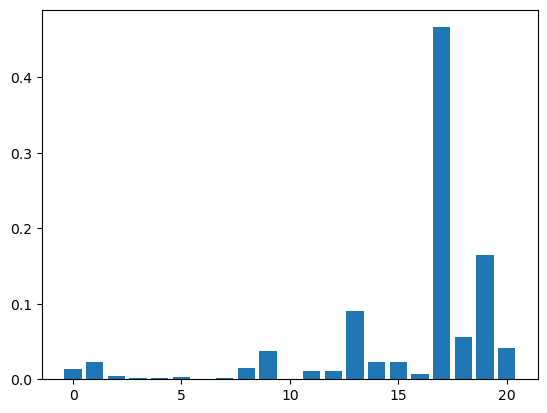

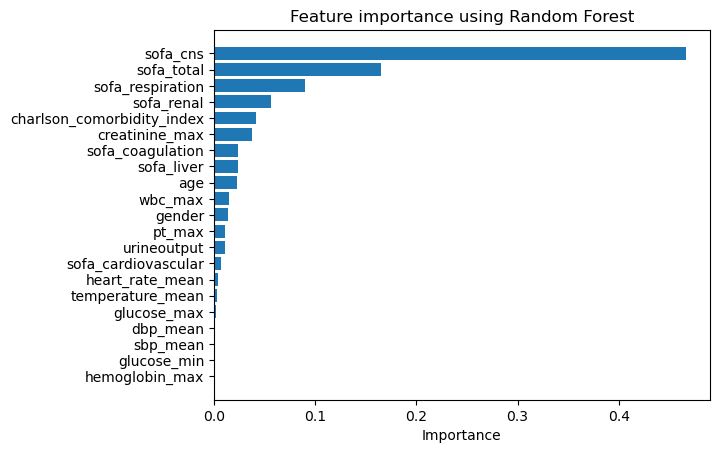

In [35]:
# 3.3.3 BUILD THE RANDOM FOREST MODEL 

# define the parameters 
param_grid = {'n_estimators': np.arange(start=200, stop=1000, step=200),
              'max_depth': np.arange(start=2, stop=6, step=1),
              'min_samples_leaf': np.arange(start=1000, stop=10000, step=2000),
              'min_samples_split': np.arange(start=2, stop=6, step=2),
              #'max_features': np.arange(start=2, stop=15, step=2),
              'criterion': [ 'entropy']}

stratifiedCV = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
treemodel = RandomForestClassifier()
best_tree = GridSearchCV(treemodel, param_grid, cv=stratifiedCV, scoring='roc_auc', n_jobs=-1)

# train the model
best_tree.fit(x_train_smote, y_train_smote)

# print the best parameters
print('Best parameters for the decision tree: {}'.format(best_tree.best_params_))

# print importance of features
importance = best_tree.best_estimator_.feature_importances_
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

# test the model
y_pred_tree = best_tree.predict(x_test)

# get feature importances and sort them in  order
importances = best_tree.best_estimator_.feature_importances_
sorted_indices = importances.argsort()[::-1][:importances.shape[0]]
# Plot the feature importances
x = data_imputed_retained.drop(['outcome'], axis=1)
feature_names = list(x.columns)
feature_names_filtered = [feature_names[i] for i in sorted_indices]

import matplotlib.pyplot as plt
plt.barh(range(x_train_smote.shape[1]), importances[sorted_indices][::-1])
plt.yticks(range(x_train_smote.shape[1]), feature_names_filtered[::-1])
plt.xlabel('Importance')
plt.title("Feature importance using Random Forest")
plt.show()

AUC for decision tree: 0.697
F1 for decision tree: 0.131
Precision for decision tree: 0.072
Recall for decision tree: 0.765
AP for decision tree: 0.063
Classification of decision tree:
Predicted     0     1
Actual               
0          6642  3910
1            93   302

Accuracy for decision tree: 0.634


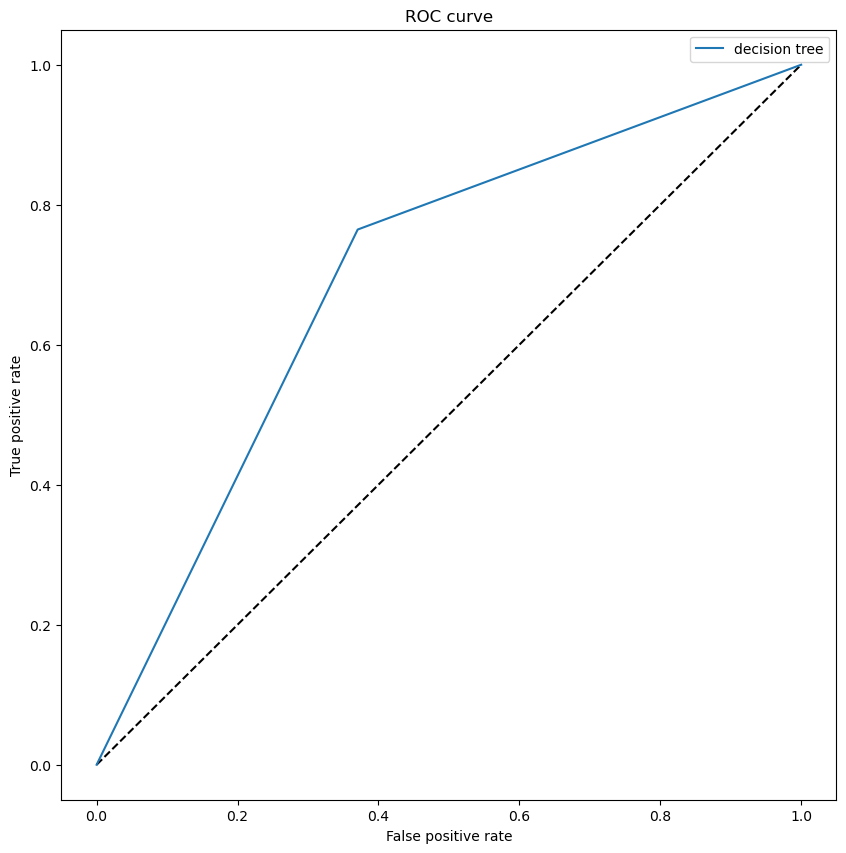

In [38]:
# 3.3.4 EVALUATE THE RANDOM FOREST MODEL

# roc
fpr, tpr, _ = roc_curve(y_test, y_pred_tree)
roc_auc = auc(fpr, tpr)
print('AUC for decision tree: {:.3f}'.format(roc_auc))

# f1
f1 = f1_score(y_test, y_pred_tree)
print('F1 for decision tree: {:.3f}'.format(f1))

# precision
precision = precision_score(y_test, y_pred_tree)
print('Precision for decision tree: {:.3f}'.format(precision))

# recall
recall = recall_score(y_test, y_pred_tree)
print('Recall for decision tree: {:.3f}'.format(recall))

# ap
ap = average_precision_score(y_test, y_pred_tree)
print('AP for decision tree: {:.3f}'.format(ap))

# binary classification
crosstab = pd.crosstab(y_test, y_pred_tree, rownames=['Actual'], colnames=['Predicted'])
print('Classification of decision tree:\n{}\n'.format(crosstab))

# accuracy
accuracy = accuracy_score(y_test, y_pred_tree)
print('Accuracy for decision tree: {:.3f}'.format(accuracy))

# 3.3.5 PLOT THE ROC CURVE FOR THE DECISION TREE MODEL
plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='decision tree')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


### 3.4 XgBOOST

In [22]:
# 3.4.1 SPLIT THE DATA INTO TRAINING AND TEST SETS, STANDARDISE THE DATA AND BALANCE THE DATASET

# specify x and y variables
x=data_imputed_retained.drop(['outcome'], axis=1)
#print(x)
y=data_imputed_retained['outcome']
#print(y)

# Do the 70-30 split

test_size = 0.3
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = test_size, random_state = 0)  

# Count the number of samples with and without the outcome variable in the training set
train_outcome_count = y_train.value_counts()
train_outcome_count.index = ['No Outcome', 'Outcome']
print('Training set:')
print(train_outcome_count)

# Count the number of samples with and without the outcome variable in the testing set
test_outcome_count = y_test.value_counts()
test_outcome_count.index = ['No Outcome', 'Outcome']
print('Testing set:')
print(test_outcome_count)

# 3.4.2 Do normalisation and smote for the train data and test data

pipetrain = imbpipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(sampling_strategy='minority'))
])

# fit the pipeline to the train data
x_train_smote, y_train_smote = pipetrain.fit_resample(x_train, y_train)
#print(x_train_smote)
#print(y_train_smote)

# check y values before and after smote
before_smote = y_train.value_counts()
after_smote = y_train_smote.value_counts()
print('Values before SMOTE: {}'.format(before_smote))
print('Values after SMOTE: {}'.format(after_smote))

# do normalisation only for the test data
scaler = StandardScaler()
x_test = scaler.fit_transform(x_test)

Training set:
No Outcome    24608
Outcome         934
Name: outcome, dtype: int64
Testing set:
No Outcome    10552
Outcome         395
Name: outcome, dtype: int64
Values before SMOTE: 0    24608
1      934
Name: outcome, dtype: int64
Values after SMOTE: 0    24608
1    24608
Name: outcome, dtype: int64


In [23]:
# 3.4.3 BUILD THE XGBOOST MODEL

# specifiy the parameters for the grid search
parameters = {
    'n_estimators':np.arange(start=200, stop=1000, step=100),
    'max_depth':np.arange(start=2,stop=6,step=2),
    'learning_rate':np.arange(start=0.01,stop=0.4,step=0.05)
}
stratifiedCV = StratifiedKFold(n_splits=5)

XGBoostlr = xgbc()
best_xgboost = GridSearchCV(XGBoostlr,param_grid=parameters,scoring='f1',cv=stratifiedCV,verbose=1,n_jobs=-1) # use all cpu cores to speedup grid search)

# train the model
best_xgboost.fit(x_train_smote,y_train_smote)
print('Best parameters for XGBoost: {}'.format(best_xgboost.best_params_))

# test the model
y_pred_boost = best_xgboost.predict(x_test)

# get feature importances and sort them in  order
importances = best_xgboost.best_estimator_.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
print('Feature ranking:')
x = data_imputed_retained.drop(['outcome'], axis=1)
feature_names = list(x.columns)
for f in range(x_train_smote.shape[1]):
    print('{}. feature {} ({})'.format(f + 1, feature_names[sorted_indices[f]], importances[sorted_indices[f]]))

x = data_imputed_retained.drop(['outcome'], axis=1)
feature_names = list(x.columns)
feature_names_filtered = [feature_names[i] for i in sorted_indices]
    
import matplotlib.pyplot as plt
plt.barh(range(x_train_smote.shape[1]), importances[sorted_indices][::-1])
plt.yticks(range(x_train_smote.shape[1]), feature_names_filtered[::-1])
plt.xlabel('Importance')
plt.title("Feature importance using XgBoost")
plt.show()

Fitting 5 folds for each of 128 candidates, totalling 640 fits
Best parameters for XGBoost: {'learning_rate': 0.21000000000000002, 'max_depth': 4, 'n_estimators': 800}


AUC for decision tree: 0.513
F1 for decision tree: 0.071
Precision for decision tree: 0.037
Recall for decision tree: 0.995
AP for decision tree: 0.037
Classification of decision tree:
Predicted    0      1
Actual               
0          331  10221
1            2    393

Accuracy for decision tree: 0.066


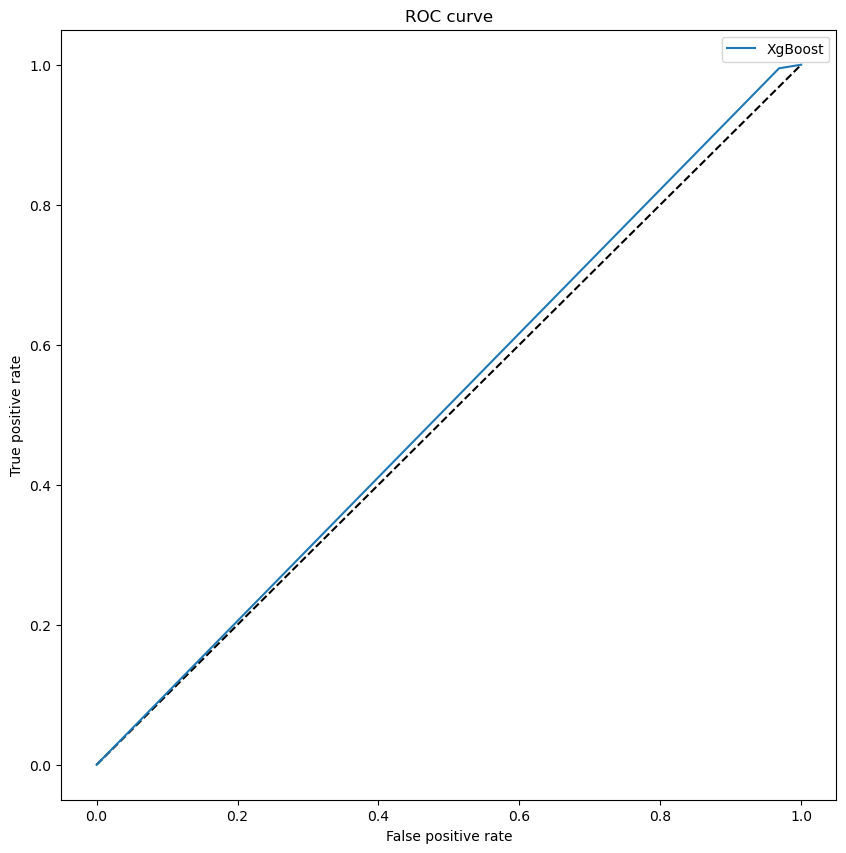

In [24]:
# 3.4.3 EVALUATE THE XgBoost MODEL

# roc
fpr, tpr, _ = roc_curve(y_test, y_pred_boost)
roc_auc = auc(fpr, tpr)
print('AUC for decision tree: {:.3f}'.format(roc_auc))

# f1
f1 = f1_score(y_test, y_pred_boost)
print('F1 for decision tree: {:.3f}'.format(f1))

# precision
precision = precision_score(y_test, y_pred_boost)
print('Precision for decision tree: {:.3f}'.format(precision))

# recall
recall = recall_score(y_test, y_pred_boost)
print('Recall for decision tree: {:.3f}'.format(recall))

# ap
ap = average_precision_score(y_test, y_pred_boost)
print('AP for decision tree: {:.3f}'.format(ap))

# binary classification
crosstab = pd.crosstab(y_test, y_pred_boost, rownames=['Actual'], colnames=['Predicted'])
print('Classification of decision tree:\n{}\n'.format(crosstab))

# accuracy
accuracy = accuracy_score(y_test, y_pred_boost)
print('Accuracy for decision tree: {:.3f}'.format(accuracy))

# 3.3.5 PLOT THE ROC CURVE FOR THE DECISION TREE MODEL
plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='XgBoost')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

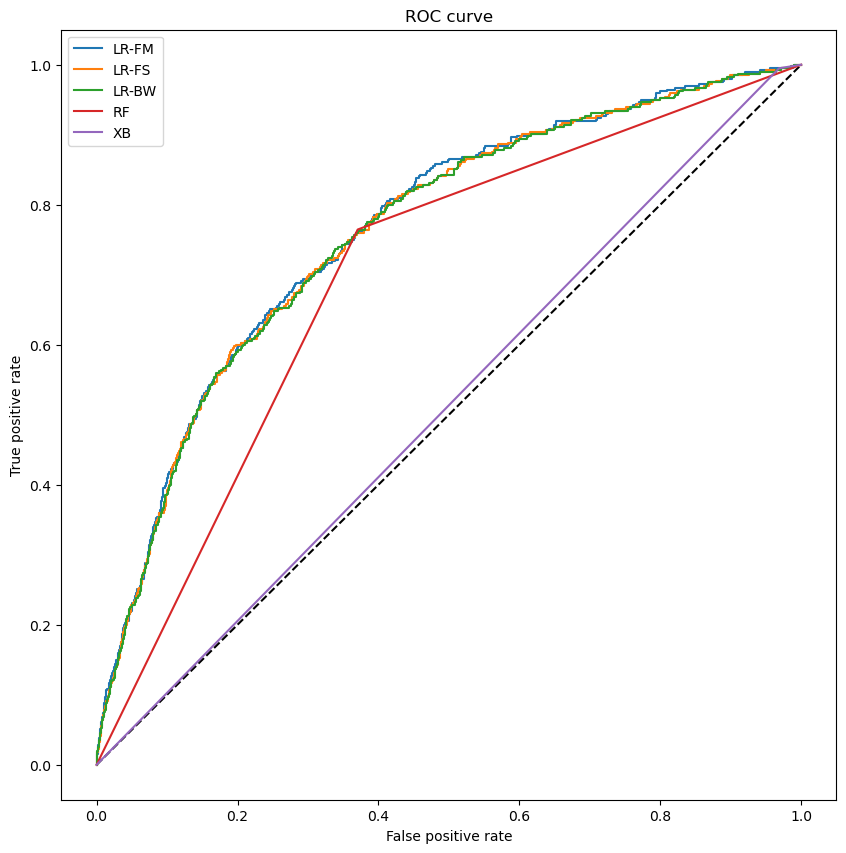

In [37]:
#  Plot the ROC curve for all models 
plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')
fpr, tpr, _ = roc_curve(y_test, y_pred_pr_full)
plt.plot(fpr, tpr, label='LR-FM')
fpr, tpr, _ = roc_curve(y_test, y_pred_pr_fs)
plt.plot(fpr, tpr, label='LR-FS')
fpr, tpr, _ = roc_curve(y_test, y_pred_pr_bw)
plt.plot(fpr, tpr, label='LR-BW')
fpr, tpr, _ = roc_curve(y_test, y_pred_tree)
plt.plot(fpr, tpr, label='RF')
fpr, tpr, _ = roc_curve(y_test, y_pred_boost)
plt.plot(fpr, tpr, label='XB')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## **4. FINDINGS AND CONCLUSIONS**

The models performed poorly for this dataset. Further review on the variables and the data is required to improve the model performance.

## **5. APPENDIX**

### 5.1. TEST DIFFERENT LEARNING RATES FOR LOGISTIC REGRESSION 

In [ ]:
#other things done

# 5.1.1 Scale the data using normalisation and oversample the minority class using SMOTE

# Normalisation and smote for the train data

pipetrain = imbpipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(sampling_strategy='minority'))
])

# fit the pipeline to the train data
x_train_smote, y_train_smote = pipetrain.fit_resample(x_train, y_train)
print(x_train_smote)
print(y_train_smote)

print(y_train.value_counts())
print(y_train_smote.value_counts())

# convert the train data into tensors for pytorch
x_train_smote = torch.tensor(x_train_smote, dtype=torch.float32)
m,n = x_train_smote.shape #m is the number of rows, n is the number of columns
y_train_smote = torch.tensor(y_train_smote, dtype=torch.float32).reshape(m,1) 
print(x_train_smote)
print(y_train_smote)

# do normalisation for the test data
#x_test= pipetrain.transform(x_test)
scaler = MinMaxScaler()
x_test = scaler.fit_transform(x_test)
y_test=y_test.to_numpy()

# convert the test data into tensors for pytorch
x_test = torch.tensor(x_test, dtype=torch.float32)
m,n = x_test.shape
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(m,1) 
print(x_test)
print(y_test)

In [ ]:
## 5.1.2 Train the data using logistic regression lr

## overview of the results
# after training the lr using different learning rates, the best learning rate is 0.01, with an average BCE loss of 0.561
# the lr is able to predict the outcome of intubation with an accuracy of 0.77, roc auc score of 0.767, recall of 0.62, 
# precision of 0.94, f1 score of 0.163, and an average precision score of 0.120


# logistic regression lr have a linear function and a sigmoid function
# for this lr, i have included all the features in the dataset

# linear 
h = torch.nn.Linear(in_features=n,out_features=1,bias=True)
sigma = torch.nn.Sigmoid()

# logistic regression = linear + sigmoid 
f = torch.nn.Sequential(h, sigma)

# we will use binary cross entropy loss function
j_bce = torch.nn.BCELoss()

learning_rates = [0.001, 0.003, 0.005, 0.007, 0.01, 0.03, 0.05, 0.07, 0.1]
best_loss = float('inf')
best_lr = None

nIter = 5000
printInterval = 500

for lr in learning_rates:
    f = torch.nn.Sequential(torch.nn.Linear(n, 1), torch.nn.Sigmoid())
    gd_optimizer = torch.optim.Adam(lr=lr, params=f.parameters())
    for i in range(nIter):
        # clear the gradient
        gd_optimizer.zero_grad()
        # compute the predictions and loss for this iteration
        pred = f(x_train_smote)
        loss = j_bce(pred, y_train_smote)
        # compute the gradient
        loss.backward()
        # update the parameters
        gd_optimizer.step()
        # print the loss every printInterval iterations
        if i == 0 or ((i+1)%printInterval) == 0:
            print(f"Learning rate {lr}, Iter {i+1}: average BCE loss is {loss.item():.3f}")
        # save the best learning rate
        if i == nIter-1:
            if loss.item() < best_loss:
                best_loss = loss.item()
                best_lr = lr

print(f"Best learning rate: {best_lr}, with average BCE loss of {best_loss:.3f}")

# 5.1.3. Test the logistic regression lr on the test data

# we will use the best learning rate to train the lr
# we need to use torch.no_grad() to stop the lr from calculating the gradient as it has already been calculated above
with torch.no_grad():
    pred_test = f(x_test)

# 5.5.3. Calculate the performance of the lr

# accuracy
threshold = 0.5
binary_pred = np.where(pred_test.squeeze()>threshold, 1,0)
label = np.where(y_test.squeeze()>0.5, 1,0)
accuracy = (binary_pred == label).sum()/binary_pred.shape[0]
print('Accuracy: {:.3f}'.format(accuracy*100))

# cross tab
print(pd.crosstab(label, binary_pred, rownames=['Actual'], colnames=['Predicted']))

# plot results
pred_fig = pd.DataFrame({'pred_prob':pred_test.squeeze().numpy(), 'label':label})
fig = px.scatter(data_frame=pred_fig, y='pred_prob', color='label')
fig.show()

# roc 
auroc = roc_auc_score(y_test, pred_test)
print('AUROC: {:.3f}'.format(auroc))

# recall
recall = recall_score(y_test, pred_test.round())
print('Recall: {:.3f}'.format(recall))

# precision
precision = precision_score(y_test, pred_test.round())
print('Precision: {:.3f}'.format(precision))

# f1
f1 = f1_score(y_test, pred_test.round())
print('F1: {:.3f}'.format(f1))

# ap
ap = average_precision_score(y_test, pred_test)
print('AP: {:.3f}'.format(ap))

# save the lr parameters for comparison with other lrs 
weight = h.weight.detach().squeeze().clone()